# Building Machine Learning Models - Complete Workflow   

<span style='color:crimson'> <span style="font-size:19px;"> **Machine Learning Algorithms Selection: Random Forest Regressor & Gradient Boosting Regressor**

For the prediction of petrophysical properties, such as porosity, permeability and water saturation, Random Forest Regressor and Gradient Boosting Regressor are suitable.

They are Ensemble Based Tree Methods; they are based on the generation of Decision Trees.

We use Regression Models since we want to predict a continuous variable. 

Advantages of the 2 regression models, since they are based on Decision Trees:
1. They do not need the normalization or scaling of the original dataset;
2. They are not sensitive to outliers, thus, outliers detection and removal are not required. 

<span style='color:crimson'> <span style="font-size:19px;"> **Importing Models and Required Dependencies** 

In [1]:
%pip install --upgrade scikit-learn==1.2.2                                                         # 1.2.2 is the latest version of scikit learn library
%pip install qbstyles                                                                              # "Quantum Black Style Library" to matplotlib figures

# Importing the models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor                                               # RandomForestRegressor supports multi output regression; GradientBoostingRegressor does not, thus the "MultiOutputRegressor" is required

# Importing the dependencies (components required, by the project, to avoid runtime errors)
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches                                                              # To create a legend with a color box
import pickle

from qbstyles import mpl_style
mpl_style(dark=False)                                                                              # Set light matplotlib style

from sklearn.model_selection import train_test_split                                               # train_test_split is a function
from sklearn.model_selection import cross_val_score, KFold                                         # cross_val_score and KFold are functions

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, mean_absolute_error  # Regression metrics

from matplotlib_inline.backend_inline import set_matplotlib_formats                                # The package "Matplotlib Inline Back-end" provides support for Matplotlib to display figures directly inline
set_matplotlib_formats('svg')                                                                      # "svg" stands for "scalable vector graphic". The plot can be scaled without compromising its quality

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<span style='color:crimson'> <span style="font-size:19px;"> **Loading the Well Log Data (WELL 3-BRSA-1215-RJS)**   

In [2]:
# Load the csv well log data to Pandas DataFrame 
df = pd.read_csv("df_1_ML.csv")
df

DEPTH         GR      HCAL  CMRP_3MS      CMFF      TCMR      PEFZ  \
0     5415.0768  44.832650  9.071985  0.025547  0.011558  0.057818  5.399678   
1     5415.2292  55.070335  9.007359  0.016499  0.008688  0.063160  5.218853   
2     5415.3816  58.339950  8.985888  0.013660  0.007378  0.071426  5.182592   
3     5415.5340  48.530777  8.988820  0.018302  0.009686  0.079272  5.071719   
4     5415.6864  31.364410  8.994384  0.025006  0.010405  0.082509  4.836956   
...         ...        ...       ...       ...       ...       ...       ...   
1574  5654.9544  65.990020  8.842665  0.025454  0.004158  0.153887  4.236645   
1575  5655.1068  66.177940  8.853786  0.032364  0.003177  0.161498  4.252467   
1576  5655.2592  66.721850  8.847485  0.036938  0.004224  0.155531  4.374145   
1577  5655.4116  67.184494  8.833298  0.034359  0.005266  0.141322  4.433830   
1578  5655.5640  67.507160  8.823120  0.029011  0.006292  0.128485  4.356368   

          RHOZ      DTCO       NPHI      AT10      AT30      AT90  
0     2.584006  69.87603  19.828733  8.855364  8.147443  7.592046  
1     2.572380  73.19949  19.217772  6.601384  6.335588  5.998077  
2     2.568452  75.06572  18.518337  5.313408  5.179097  4.954828  
3     2.576464  74.51601  17.011644  4.616776  4.474806  4.309635  
4     2.598663  71.71368  14.906008  4.396391  4.172311  4.032864  
...        ...       ...        ...       ...       ...       ...  
1574  2.460535  84.57068  24.128416  2.139533  2.036844  1.982871  
1575  2.472680  82.03125  22.505919  2.321361  2.180649  2.114672  
1576  2.472683  80.80873  21.892065  2.384136  2.219930  2.146264  
1577  2.468500  81.19625  22.098242  2.388649  2.218824  2.138570  
1578  2.466278  82.65371  22.653835  2.251253  2.100351  2.020773  

[1579 rows x 13 columns]

<span style='color:crimson'> <span style="font-size:19px;"> **Specifying Predictors & Target** 

The target of the RF and GB regression algorithms is to build a model which is able to predict a measured or calculated feature (dependent continuous variable) starting from a set of input features (independent variables).

The Independent Variable(s), or called Predictor(s), is(are) the Input(s) to the model.  

The Dependent Variable(s), or called Response(s), is(are) the Output(s) of the model. 

In this case, for NMR Effective Porosity (CMRP_3MS), NMR Free Fluid (CMFF) and NMR Total Porosity (TCMR) Predictions, measured features, the following Input variables are considered:

GR          .gAPI = Gamma-Ray

HCAL        .in = HRCC Calibrated Caliper

PEFZ        .b/e = HRDD Standard Resolution Formation Photoelectric Factor

RHOZ        .g/cm3 = HRDD Standard Resolution Formation Density

DTCO        .us/ft = Delta-T Compressional (Compressional_Slowness)

NPHI        .m3/m3 = Thearmal Neutron Porosity (Ratio Method) 

AT90        .ohm.m = Array Induction Two Foot Resistivity A90

In [3]:
predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  
outputs = ["CMRP_3MS","CMFF","TCMR"]  # They are predicted at the same time 

In [4]:
X = df[predictors]
y = df[outputs]

<span style='color:crimson'> <span style="font-size:19px;"> **Training & Test Well Log Datasets** 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To split the data into training and test datasets we use the "train_test_split" function.

We consider the following parameters:
1. X,y: are the variables to be splitted;
2. train_size = None: the value is automatically set to the complement of the test size (0.8);
3. test_size = 0.2 (20%): it represents the proportion of the dataset to include in the test split;
4. shuffle = True (by default): whether or not to shuffle the data before splitting;
5. random_state = 42: pass an int, we chose 42, for reproducible output across multiple function calls. It has    to be set only when "shufle=True".

In [6]:
# Shape of the training and test datasets 
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1579, 7) (1579, 3) (1263, 7) (316, 7) (1263, 3) (316, 3)


<span style='color:crimson'> <span style="font-size:19px;"> **Cross-Validation of the Models** 

We consider only the training dataset and we have to cross-validate the two models.

Notably, we consider the K-Fold Cross-Validation technique.

According to this technique, the training dataset (80% of the original dataset) is split randomly, into k number of subsets or called folds. The model is trained on k-1 folds of training set and evaluated on the remaining fold of validation set.
This procedure is iterated for k-times; for each iteration, the model is evaluated on a different validation
set. 

This technique is used in order to obtain an "average accuracy" of our models in a more reliable way. Instead of a simple "Training and Test phase", we have a "Training, Validation and Test phase". 

In this case, the accuracy of the models is given by the "Coefficient of Determination" which is a measure that assesses the ability of a model to predict. 

Note: this step can be skipped since it will be carried out again through the Optimization Process.

<span style='color:crimson'> <span style="font-size:19px;"> **K-Fold Cross-Validation** 

We create the two models without specifying any "hyperparameter" and by means of the "cross_val_score" function we can split the training dataset into different k-folds; since we are dealing with a large training dataset, we choose k=10. This function allows also to calculate the "accuracy" of the models for each iteration.
Thus, we obtain 10 accuracy values and we can calculate the "average accuracy" for each model. 

Average Accuracy = (Accuracy iteration 1 + ... + Accuracy iteration 10)/10 

In [7]:
# Create the models 

# Random Forest Model (RF)
rf_model = RandomForestRegressor(random_state=42) 

# Gradient Boosting Model (GB)
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

For the "cross_val_score" function, we consider the following parameters:
1. model;
2. training dataset;
3. number of folds, cv=10;
4. regression metrics that we want to calculate, (Coefficient of Determination) scoring='r2'.

In [8]:
# RANDOM FOREST MODEL 

# Number of folds 
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross validation score
cv_score_rf = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')
cv_score_rf = np.round(cv_score_rf,4 )         # To have only 4 decimal places; cv_score_rf array 
print(cv_score_rf)                             # 10 accuracy values are printed 

# To obtain an average value of r2
mean_r2_rf = sum(cv_score_rf)/len(cv_score_rf) # len(cv_score_rf)=10
mean_r2_rf = mean_r2_rf*100                    # To convert the average value into a percentage value
mean_r2_rf = round(mean_r2_rf,2)               # To have only 2 decimal places 
print(mean_r2_rf) 

[0.8713 0.9093 0.8883 0.9169 0.9059 0.9106 0.9294 0.9118 0.8962 0.9256]
90.65


In [9]:
# GRADIENT BOOSTING MODEL 

# Number of folds 
kf = KFold(n_splits=10, shuffle=True, random_state=42) 

# Cross validation score
cv_score_gb = cross_val_score(gb_model, X_train, y_train, cv=kf, scoring='r2')
cv_score_gb = np.round(cv_score_gb,4)          # To have only 4 decimal places; cv_score_rf array
print(cv_score_gb)                             # 10 accuracy values are printed

# To obtain an average value of r2
mean_r2_gb = sum(cv_score_gb)/len(cv_score_gb) # len(cv_score_rf)=10
mean_r2_gb = mean_r2_gb*100                    # To convert the average value into a percentage value 
mean_r2_gb = round(mean_r2_gb, 2)              # To have only 2 decimal places
print(mean_r2_gb) 

[0.8717 0.8933 0.8806 0.905  0.8806 0.8903 0.9122 0.9032 0.8877 0.8976]
89.22


In order to compare the models, at the same time, it is better to write a "for loop" and to define a function "compare_models_cv(). This is equivalent to what has been done before. 

In [10]:
# Create Models 
# Random Forest Model 
rf_model = RandomForestRegressor(random_state=42)  

# Gradient Boosting Model 
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# List of models 
models = [rf_model, gb_model]

# Number of folds 
kf = KFold(n_splits=10, shuffle=True, random_state=42) 

# For loop 
def compare_models_cv():  
    for model in models:
        r2_score = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
        r2_score = np.round(r2_score,4)
        mean_r2 = sum(r2_score)/len(r2_score)
        mean_r2 = mean_r2*100
        mean_r2 = round(mean_r2,2)

        print('Coefficient of Determination for', model, '=', r2_score)
        print('Average % Coefficient of Determination for', model, '=', mean_r2)
        print('============================================')

In [11]:
# Call the function 
compare_models_cv() 

Coefficient of Determination for RandomForestRegressor(random_state=42) = [0.8713 0.9093 0.8883 0.9169 0.9059 0.9106 0.9294 0.9118 0.8962 0.9256]
Average % Coefficient of Determination for RandomForestRegressor(random_state=42) = 90.65
Coefficient of Determination for MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)) = [0.8717 0.8933 0.8806 0.905  0.8806 0.8903 0.9122 0.9032 0.8877 0.8976]
Average % Coefficient of Determination for MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)) = 89.22


<span style='color:crimson'> <span style="font-size:19px;">  **Hyperparameters Tuning (RandomizedSearchCV) - Optimization Problem** 

We re-consider the training dataset and we use the Randomized Search Cross Validation technique to determine the optimal hyperparameter values for the Random Forest & Gradient Boosting models. 

We start implementing the Random Search by defining a grid of hyperparameters that will be randomly sampled when calling the function "RandomizedSearchCV()". Moreover, the models are cross-validated, for the second time, on these random combinations of hyperparameters. 

The parameters of the "RandomizedSearchCV()" function are:
1. The model without any hyperparameter;
2. The grid of hyperparameters;
3. The number of combinations to be randomly sampled (n_iter=20);
4. The number of k-folds into which the training dataset is splitted (cv=10).

The techinque returns the optimal combination of hyperparameters, for the two models. 

In [12]:
# Import the dependencies 
from sklearn.model_selection import RandomizedSearchCV

**RANDOM FOREST HYPERPARAMETERS GRID**

We consider the following hyperparameters:
1. n_estimators = number of trees in the forest;
2. max_depth = the maximum depth of the tree;
3. criterion = the function that measures the quality of the split.

In [13]:
# RANDOM FOREST Hyperparameters

# Number of trees to be used
rf_n_estimators = [100, 150, 200, 250, 300, 350, 400]

# Maximum number of levels in tree
rf_max_depth = [5, 10, 15, 20, 25]

# Criterion to split on
rf_criterion = ['squared_error']                         # "squared_error" is by default. It is optional

# Create the grid 
rf_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'criterion': rf_criterion}

In [14]:
# Model to be tuned 
rf_model = RandomForestRegressor(random_state=42)        # Shuffle=True by default

# Create the random search Random Forest 
rf_random = RandomizedSearchCV(rf_model, rf_grid, n_iter=20, cv=10, random_state=42)

# Fit the random search model 
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400]},
                   random_state=42)

In [15]:
# Print the results 
rf_random.cv_results_

{'mean_fit_time': array([1.42946887, 1.34042633, 1.0150202 , 0.40451584, 0.59119852,
        0.60845678, 1.37541077, 1.1686471 , 0.50098536, 0.78500683,
        0.66967382, 1.42764294, 0.21771889, 0.65259709, 0.98928292,
        1.62137249, 0.76619949, 1.00453434, 0.32591696, 0.43480093]),
 'std_fit_time': array([0.03102645, 0.00824707, 0.00740334, 0.00096641, 0.00539309,
        0.00187809, 0.00675401, 0.005757  , 0.00118753, 0.0013135 ,
        0.00425232, 0.01401343, 0.0005346 , 0.00439478, 0.01099773,
        0.01148625, 0.01739633, 0.00756435, 0.00068567, 0.00102872]),
 'mean_score_time': array([0.02003393, 0.01919804, 0.01429956, 0.0062433 , 0.00872526,
        0.00885606, 0.01890731, 0.01673791, 0.00774384, 0.01119702,
        0.01007421, 0.01967294, 0.0047209 , 0.01206264, 0.01408165,
        0.02225709, 0.01383874, 0.01463482, 0.00652497, 0.00840929]),
 'std_score_time': array([5.25070696e-04, 2.98662952e-04, 3.37681906e-04, 8.31354372e-05,
        1.36933286e-04, 8.64537460e-

In [16]:
# Print the best hyperparameters
# Combination that gives the highest accuracy (coefficient of determination) during the cross-validation
best_parameters = rf_random.best_params_
print(best_parameters) 

{'n_estimators': 400, 'max_depth': 20, 'criterion': 'squared_error'}


In [17]:
# Print the accuracy we get for the "best combination"
highest_accuracy = rf_random.best_score_ 
highest_accuracy = round(highest_accuracy,4)
highest_accuracy = highest_accuracy*100
print('Coefficient of Determination for the Random Forest =', highest_accuracy)

Coefficient of Determination for the Random Forest = 90.75


In [18]:
# Load the results to Pandas DataFrame 
results = pd.DataFrame(rf_random.cv_results_) 
results.head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.429469      0.031026         0.020034        0.000525   
1        1.340426      0.008247         0.019198        0.000299   
2        1.015020      0.007403         0.014300        0.000338   
3        0.404516      0.000966         0.006243        0.000083   
4        0.591199      0.005393         0.008725        0.000137   
5        0.608457      0.001878         0.008856        0.000086   
6        1.375411      0.006754         0.018907        0.000129   
7        1.168647      0.005757         0.016738        0.000058   
8        0.500985      0.001188         0.007744        0.000098   
9        0.785007      0.001314         0.011197        0.000155   
10       0.669674      0.004252         0.010074        0.000176   
11       1.427643      0.014013         0.019673        0.000374   
12       0.217719      0.000535         0.004721        0.000054   
13       0.652597      0.004395         0.012063        0.000144   
14       0.989283      0.010998         0.014082        0.000425   
15       1.621372      0.011486         0.022257        0.000270   
16       0.766199      0.017396         0.013839        0.000110   
17       1.004534      0.007564         0.014635        0.000334   
18       0.325917      0.000686         0.006525        0.000086   
19       0.434801      0.001029         0.008409        0.000160   

   param_n_estimators param_max_depth param_criterion  \
0                 350              20   squared_error   
1                 400              10   squared_error   
2                 250              20   squared_error   
3                 100              20   squared_error   
4                 150              15   squared_error   
5                 150              25   squared_error   
6                 350              15   squared_error   
7                 350              10   squared_error   
8                 150              10   squared_error   
9                 200              15   squared_error   
10                200              10   squared_error   
11                350              25   squared_error   
12                100               5   squared_error   
13                300               5   squared_error   
14                250              15   squared_error   
15                400              20   squared_error   
16                350               5   squared_error   
17                300              10   squared_error   
18                150               5   squared_error   
19                200               5   squared_error   

                                               params  split0_test_score  \
0   {'n_estimators': 350, 'max_depth': 20, 'criter...           0.924147   
1   {'n_estimators': 400, 'max_depth': 10, 'criter...           0.919144   
2   {'n_estimators': 250, 'max_depth': 20, 'criter...           0.923748   
3   {'n_estimators': 100, 'max_depth': 20, 'criter...           0.924672   
4   {'n_estimators': 150, 'max_depth': 15, 'criter...           0.924386   
5   {'n_estimators': 150, 'max_depth': 25, 'criter...           0.924489   
6   {'n_estimators': 350, 'max_depth': 15, 'criter...           0.924300   
7   {'n_estimators': 350, 'max_depth': 10, 'criter...           0.919033   
8   {'n_estimators': 150, 'max_depth': 10, 'criter...           0.918531   
9   {'n_estimators': 200, 'max_depth': 15, 'criter...           0.924130   
10  {'n_estimators': 200, 'max_depth': 10, 'criter...           0.918498   
11  {'n_estimators': 350, 'max_depth': 25, 'criter...           0.924256   
12  {'n_estimators': 100, 'max_depth': 5, 'criteri...           0.890730   
13  {'n_estimators': 300, 'max_depth': 5, 'criteri...           0.891001   
14  {'n_estimators': 250, 'max_depth': 15, 'criter...           0.924157   
15  {'n_estimators': 400, 'max_depth': 20, 'criter...           0.924486   
16  {'n_estimators': 350, 'max_depth': 5, 'criteri...           0.890983   
17  {'n_e

In [19]:
# Define the columns of interest
results_of_interest = results[['param_n_estimators','param_max_depth','param_criterion','params','mean_test_score']]
results_of_interest.head(20)

param_n_estimators param_max_depth param_criterion  \
0                 350              20   squared_error   
1                 400              10   squared_error   
2                 250              20   squared_error   
3                 100              20   squared_error   
4                 150              15   squared_error   
5                 150              25   squared_error   
6                 350              15   squared_error   
7                 350              10   squared_error   
8                 150              10   squared_error   
9                 200              15   squared_error   
10                200              10   squared_error   
11                350              25   squared_error   
12                100               5   squared_error   
13                300               5   squared_error   
14                250              15   squared_error   
15                400              20   squared_error   
16                350               5   squared_error   
17                300              10   squared_error   
18                150               5   squared_error   
19                200               5   squared_error   

                                               params  mean_test_score  
0   {'n_estimators': 350, 'max_depth': 20, 'criter...         0.907486  
1   {'n_estimators': 400, 'max_depth': 10, 'criter...         0.904022  
2   {'n_estimators': 250, 'max_depth': 20, 'criter...         0.906972  
3   {'n_estimators': 100, 'max_depth': 20, 'criter...         0.906503  
4   {'n_estimators': 150, 'max_depth': 15, 'criter...         0.906129  
5   {'n_estimators': 150, 'max_depth': 25, 'criter...         0.906507  
6   {'n_estimators': 350, 'max_depth': 15, 'criter...         0.907088  
7   {'n_estimators': 350, 'max_depth': 10, 'criter...         0.903977  
8   {'n_estimators': 150, 'max_depth': 10, 'criter...         0.902875  
9   {'n_estimators': 200, 'max_depth': 15, 'criter...         0.906208  
10  {'n_estimators': 200, 'max_depth': 10, 'criter...         0.903064  
11  {'n_estimators': 350, 'max_depth': 25, 'criter...         0.907390  
12  {'n_estimators': 100, 'max_depth': 5, 'criteri...         0.872546  
13  {'n_estimators': 300, 'max_depth': 5, 'criteri...         0.873274  
14  {'n_estimators': 250, 'max_depth': 15, 'criter...         0.906585  
15  {'n_estimators': 400, 'max_depth': 20, 'criter...         0.907544  
16  {'n_estimators': 350, 'max_depth': 5, 'criteri...         0.873268  
17  {'n_estimators': 300, 'max_depth': 10, 'criter...         0.903831  
18  {'n_estimators': 150, 'max_depth': 5, 'criteri...         0.872585  
19  {'n_estimators': 200, 'max_depth': 5, 'criteri...         0.872838

**GRADIENT BOOSTING HYPERPARAMETERS GRID**

We consider the following hyperparameters:
1. n_estimators = the number of boosting stages to perform (the number of trees in the forest);
2. max_depth = the maximum depth of each tree;
3. learning_rate = to slow down the learning process;
4. criterion = the function that measures the quality of the split. 

In [20]:
# GRADIENT BOOSTING Hyperparameters 

# Number of trees to be used 
gb_n_estimators = [100, 150, 200, 250, 300, 350, 400]

# Maximum number of levels in tree
gb_max_depth = [5, 10, 15, 20, 25]

# Learning rate 
gb_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Criterion to split on
gb_criterion = ['squared_error']                       # It is optional 

# Create the grid 
gb_grid = {'estimator__n_estimators': gb_n_estimators,
           'estimator__max_depth': gb_max_depth,
           'estimator__learning_rate': gb_rate,
           'estimator__criterion': gb_criterion}

In [21]:
# Model to be tuned 
gb_model = GradientBoostingRegressor(random_state=42) # Shuffle=True by default 

# Create the random search Gradient Boosting
gb_random = RandomizedSearchCV(MultiOutputRegressor(gb_model), gb_grid, n_iter=20, cv=10, random_state=42)

# Fit the random search model 
gb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)),
                   n_iter=20,
                   param_distributions={'estimator__criterion': ['squared_error'],
                                        'estimator__learning_rate': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6],
                                        'estimator__max_depth': [5, 10, 15, 20,
                                                                 25],
                                        'estimator__n_estimators': [100, 150,
                                                                    200, 250,
                                                                    300, 350,
                                                                    400]},
                   random_state=42)

In [22]:
# Print the results 
gb_random.cv_results_

{'mean_fit_time': array([2.63626058, 0.54423683, 1.17545741, 0.42549272, 1.34186206,
        0.65259435, 3.79550686, 1.27425437, 2.97446601, 0.34832153,
        0.65007246, 1.40368171, 0.44917002, 0.57127869, 2.64228268,
        2.07553771, 0.54589281, 4.18248374, 0.44234426, 0.85512505]),
 'std_fit_time': array([0.0446431 , 0.00669913, 0.0496919 , 0.00980696, 0.03726875,
        0.03129885, 0.01855825, 0.01768229, 0.01012486, 0.00986634,
        0.0067773 , 0.01324799, 0.00623499, 0.01061862, 0.02803993,
        0.01194491, 0.01298665, 0.23518788, 0.00995288, 0.03287679]),
 'mean_score_time': array([0.00863984, 0.00343397, 0.00478454, 0.00310318, 0.005494  ,
        0.00350153, 0.008267  , 0.00419207, 0.00793409, 0.00283694,
        0.00360911, 0.00420828, 0.00312321, 0.00349073, 0.00948372,
        0.00405107, 0.00353122, 0.01080809, 0.00332782, 0.00432553]),
 'std_score_time': array([2.43476047e-04, 2.15550002e-04, 2.84438937e-04, 1.49832299e-04,
        2.20025506e-04, 8.40685175e-

In [23]:
# Print the best hyperparameters. 
# Combination that gives the highest accuracy (coefficient of determination)
best_parameters = gb_random.best_params_
print(best_parameters)  

{'estimator__n_estimators': 250, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.3, 'estimator__criterion': 'squared_error'}


In [24]:
# Print the accuracy we get for the "best combination"
highest_accuracy = gb_random.best_score_
highest_accuracy = round(highest_accuracy,4)
highest_accuracy = highest_accuracy*100
print('Coefficient of Determination for the Gradient Boosting =', highest_accuracy)

Coefficient of Determination for the Gradient Boosting = 89.84


In [25]:
# Load the results to Pandas DataFrame 
results = pd.DataFrame(gb_random.cv_results_) 
results.head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.636261      0.044643         0.008640        0.000243   
1        0.544237      0.006699         0.003434        0.000216   
2        1.175457      0.049692         0.004785        0.000284   
3        0.425493      0.009807         0.003103        0.000150   
4        1.341862      0.037269         0.005494        0.000220   
5        0.652594      0.031299         0.003502        0.000084   
6        3.795507      0.018558         0.008267        0.000631   
7        1.274254      0.017682         0.004192        0.000153   
8        2.974466      0.010125         0.007934        0.000319   
9        0.348322      0.009866         0.002837        0.000029   
10       0.650072      0.006777         0.003609        0.000113   
11       1.403682      0.013248         0.004208        0.000063   
12       0.449170      0.006235         0.003123        0.000199   
13       0.571279      0.010619         0.003491        0.000107   
14       2.642283      0.028040         0.009484        0.000467   
15       2.075538      0.011945         0.004051        0.000093   
16       0.545893      0.012987         0.003531        0.000233   
17       4.182484      0.235188         0.010808        0.000525   
18       0.442344      0.009953         0.003328        0.000344   
19       0.855125      0.032877         0.004326        0.000301   

   param_estimator__n_estimators param_estimator__max_depth  \
0                            200                         25   
1                            300                         25   
2                            100                         15   
3                            250                         20   
4                            300                         20   
5                            150                         15   
6                            250                         10   
7                            100                         10   
8                            200                         10   
9                            100                         20   
10                           250                         25   
11                           350                         10   
12                           300                         25   
13                           100                         20   
14                           150                         15   
15                           250                          5   
16                           300                         20   
17                           300                         15   
18                           100                         25   
19                           200                         20   

   param_estimator__learning_rate param_estimator__criterion  \
0                             0.1              squared_error   
1                             0.5              squared_error   
2                             0.3              squared_error   
3                             0.6              squared_error   
4                             0.2              squared_error   
5                             0.5              squared_error   
6                             0.2              squared_error   
7                             0.6              squared_error   
8                             0.1              squared_error   
9                             0.6              squared_error   
10                            0.4              squared_error   
11                            0.6              squared_error   
12                            0.6              squared_error   
13                            0.4              squared_error   
14                            0.1              squared_error   
15                            0.3              squared_error   
16                            0.5              squared_error   
17                            0.1              squared_error   
18                            0.5  

In [26]:
# Define the column of interest 
results_of_interest = results[['param_estimator__n_estimators','param_estimator__max_depth','param_estimator__learning_rate','params','mean_test_score']]
results_of_interest.head(20)

param_estimator__n_estimators param_estimator__max_depth  \
0                            200                         25   
1                            300                         25   
2                            100                         15   
3                            250                         20   
4                            300                         20   
5                            150                         15   
6                            250                         10   
7                            100                         10   
8                            200                         10   
9                            100                         20   
10                           250                         25   
11                           350                         10   
12                           300                         25   
13                           100                         20   
14                           150                         15   
15                           250                          5   
16                           300                         20   
17                           300                         15   
18                           100                         25   
19                           200                         20   

   param_estimator__learning_rate  \
0                             0.1   
1                             0.5   
2                             0.3   
3                             0.6   
4                             0.2   
5                             0.5   
6                             0.2   
7                             0.6   
8                             0.1   
9                             0.6   
10                            0.4   
11                            0.6   
12                            0.6   
13                            0.4   
14                            0.1   
15                            0.3   
16                            0.5   
17                            0.1   
18                            0.5   
19                            0.3   

                                               params  mean_test_score  
0   {'estimator__n_estimators': 200, 'estimator__m...         0.843451  
1   {'estimator__n_estimators': 300, 'estimator__m...         0.839798  
2   {'estimator__n_estimators': 100, 'estimator__m...         0.863055  
3   {'estimator__n_estimators': 250, 'estimator__m...         0.845718  
4   {'estimator__n_estimators': 300, 'estimator__m...         0.848491  
5   {'estimator__n_estimators': 150, 'estimator__m...         0.860658  
6   {'estimator__n_estimators': 250, 'estimator__m...         0.890998  
7   {'estimator__n_estimators': 100, 'estimator__m...         0.876927  
8   {'estimator__n_estimators': 200, 'estimator__m...         0.890711  
9   {'estimator__n_estimators': 100, 'estimator__m...         0.845718  
10  {'estimator__n_estimators': 250, 'estimator__m...         0.841195  
11  {'estimator__n_estimators': 350, 'estimator__m...         0.876927  
12  {'estimator__n_estimators': 300, 'estimator__m...         0.838961  
13  {'estimator__n_estimators': 100, 'estimator__m...         0.845312  
14  {'estimator__n_estimators': 150, 'estimator__m...         0.864858  
15  {'estimator__n_estimators': 250, 'estimator__m...         0.898358  
16  {'estimator__n_estimators': 300, 'estimator__m...         0.843775  
17  {'estimator__n_estimators': 300, 'estimator__m...         0.864858  
18  {'estimator__n_estimators': 100, 'estimator__m...         0.839798  
19  {'estimator__n_estimators': 200, 'estimator__m...         0.846557

<span style='color:crimson'> <span style="font-size:19px;"> **Evaluation of the Tuned Models**

We consider the Test Dataset or, also called, the Hold-Out Dataset (20% of the Original Dataset) and we perform the prediction on this Dataset which is the "unseen" Dataset.

In [27]:
# Create the tuned Random Forest 
rf_final_model=RandomForestRegressor(n_estimators=400, max_depth=20, random_state=42, criterion = 'squared_error')

In [28]:
# Create the tuned Gradient Boosting 
gb_final_model=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=250, learning_rate=0.3, max_depth=5, random_state=42))

In [29]:
# Train the tuned Random Forest 
rf_final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=42)

In [30]:
# Train the tuned Gradient Boosting 
gb_final_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.3,
                                                         max_depth=5,
                                                         n_estimators=250,
                                                         random_state=42))

In [31]:
# Prediction on Test data (RF)
y_pred_rf = rf_final_model.predict(X_test)

In [32]:
# Prediction on Test data (GB)
y_pred_gb = gb_final_model.predict(X_test)

In [33]:
# Extract output 1, output 2 and output 3
y_test_out1 = y_test.drop(columns=["CMFF","TCMR"])      # CMRP_3MS
y_test_out2 = y_test.drop(columns=["CMRP_3MS","TCMR"])  # CMFF
y_test_out3 = y_test.drop(columns=["CMRP_3MS","CMFF"])  # TCMR

**RANDOM FOREST MODEL**

In [34]:
# Extract the predicted values for output 1, output 2 and output 3
y_pred_out1_rf = y_pred_rf[:, 0]
y_pred_out2_rf = y_pred_rf[:, 1]
y_pred_out3_rf = y_pred_rf[:, 2]

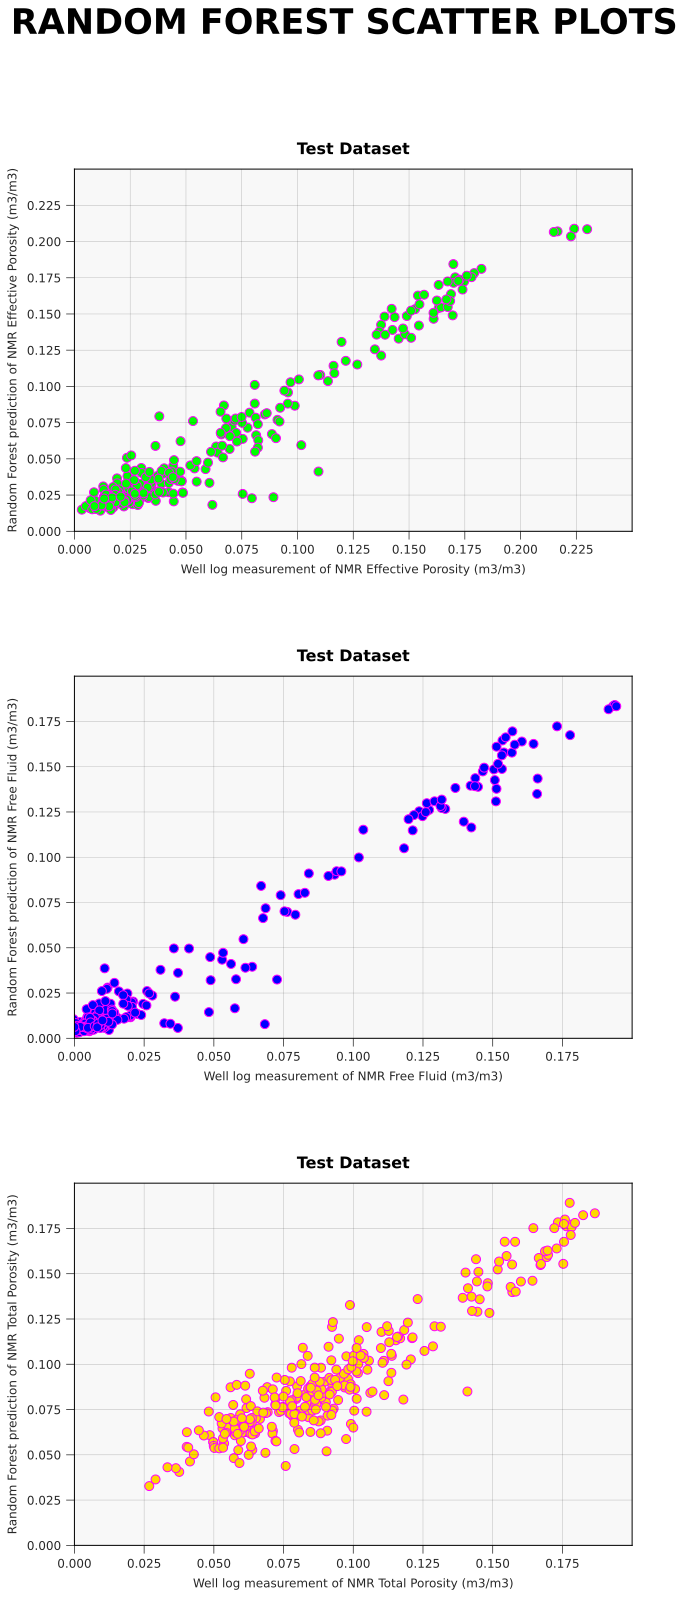

In [35]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("RANDOM FOREST SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_test_out1,y_pred_out1_rf, s=80, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Random Forest prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax1.set_xlim(0,0.25)
ax1.set_ylim(0,0.25)
ax1.set_xticks(np.arange(0, 0.25, 0.025))
ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Second Scatter Plot
ax2.scatter(y_test_out2,y_pred_out2_rf, s=80, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Random Forest prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax2.set_xlim(0,0.200)
ax2.set_ylim(0,0.200)
ax2.set_xticks(np.arange(0, 0.200, 0.025))
ax2.set_yticks(np.arange(0, 0.200, 0.025))

# Third Scatter Plot 
ax3.scatter(y_test_out3,y_pred_out3_rf, s=80, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Random Forest prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax3.set_xlim(0,0.200)
ax3.set_ylim(0,0.200)
ax3.set_xticks(np.arange(0, 0.200, 0.025))
ax3.set_yticks(np.arange(0, 0.200, 0.025))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

In [36]:
# Otput 1, Output 2 and Output 3 should be converted into arrays 
y_test_out1_ = np.array(y_test_out1)
y_test_out2_ = np.array(y_test_out2)
y_test_out3_ = np.array(y_test_out3)

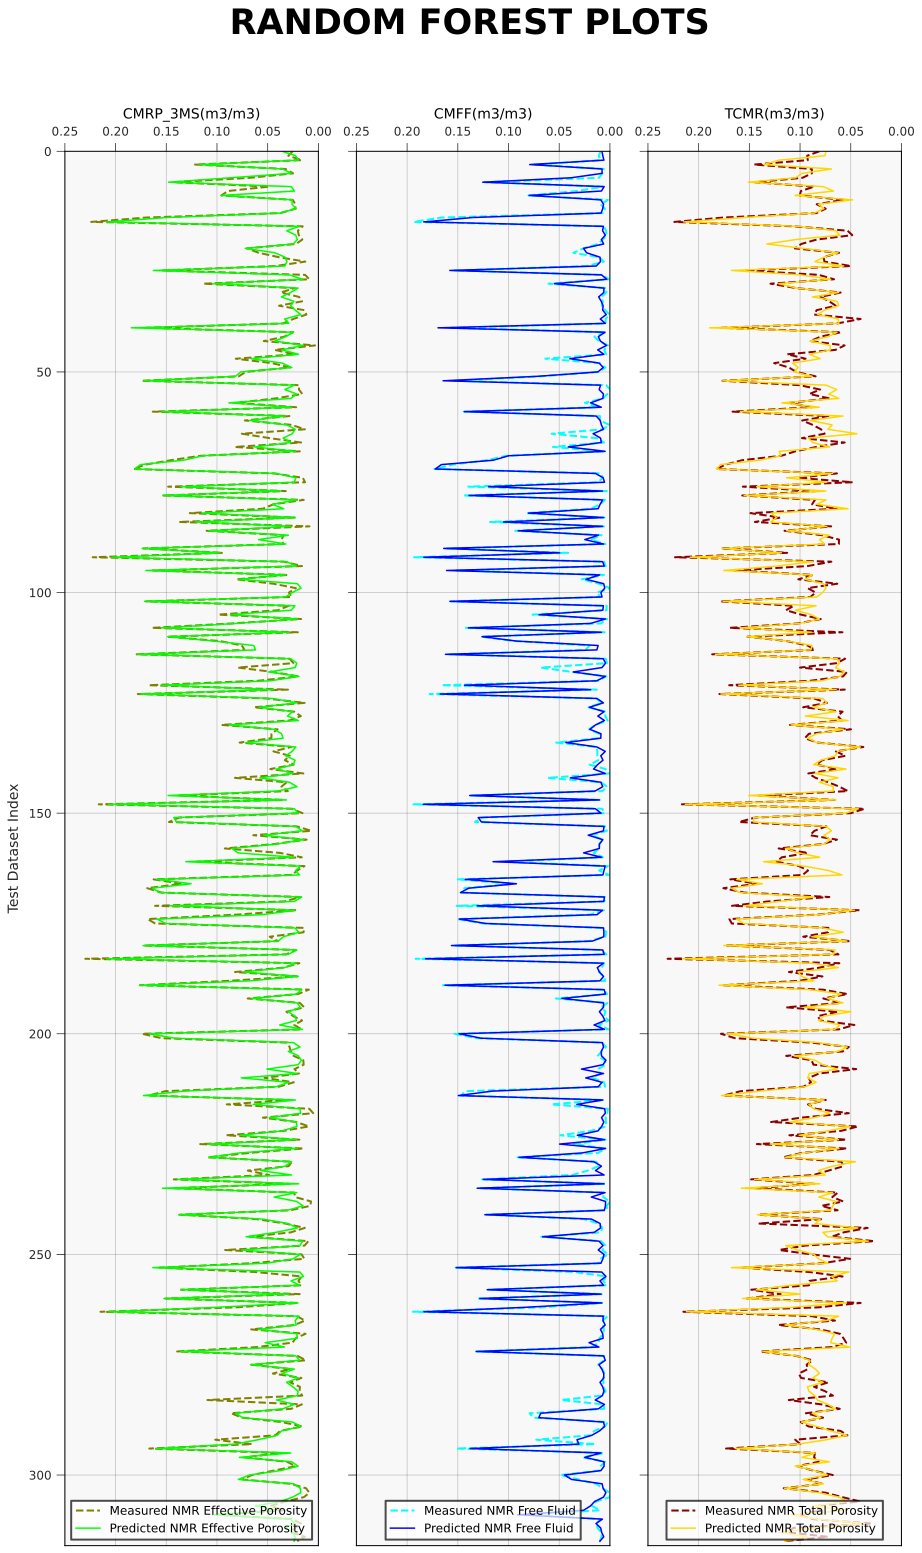

In [37]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,25))
fig.suptitle("RANDOM FOREST PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.15)

#Set up the subplots grid
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1) 

x_ax = range(len(X_test))


# First Plot
ax1.plot(y_test_out1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_pred_out1_rf, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Test Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_test_out2_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_pred_out2_rf, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_test_out3_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_pred_out3_rf, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Set xlim() and ylim()
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(316,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.7)
    
# Hide tick labels on the y-axis
for ax in [ax2,ax3]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

**GRADIENT BOOSTING MODEL**

In [38]:
# Extract the predicted values for output 1, output 2 and output 3
y_pred_out1_gb = y_pred_gb[:, 0]
y_pred_out2_gb = y_pred_gb[:, 1]
y_pred_out3_gb = y_pred_gb[:, 2]

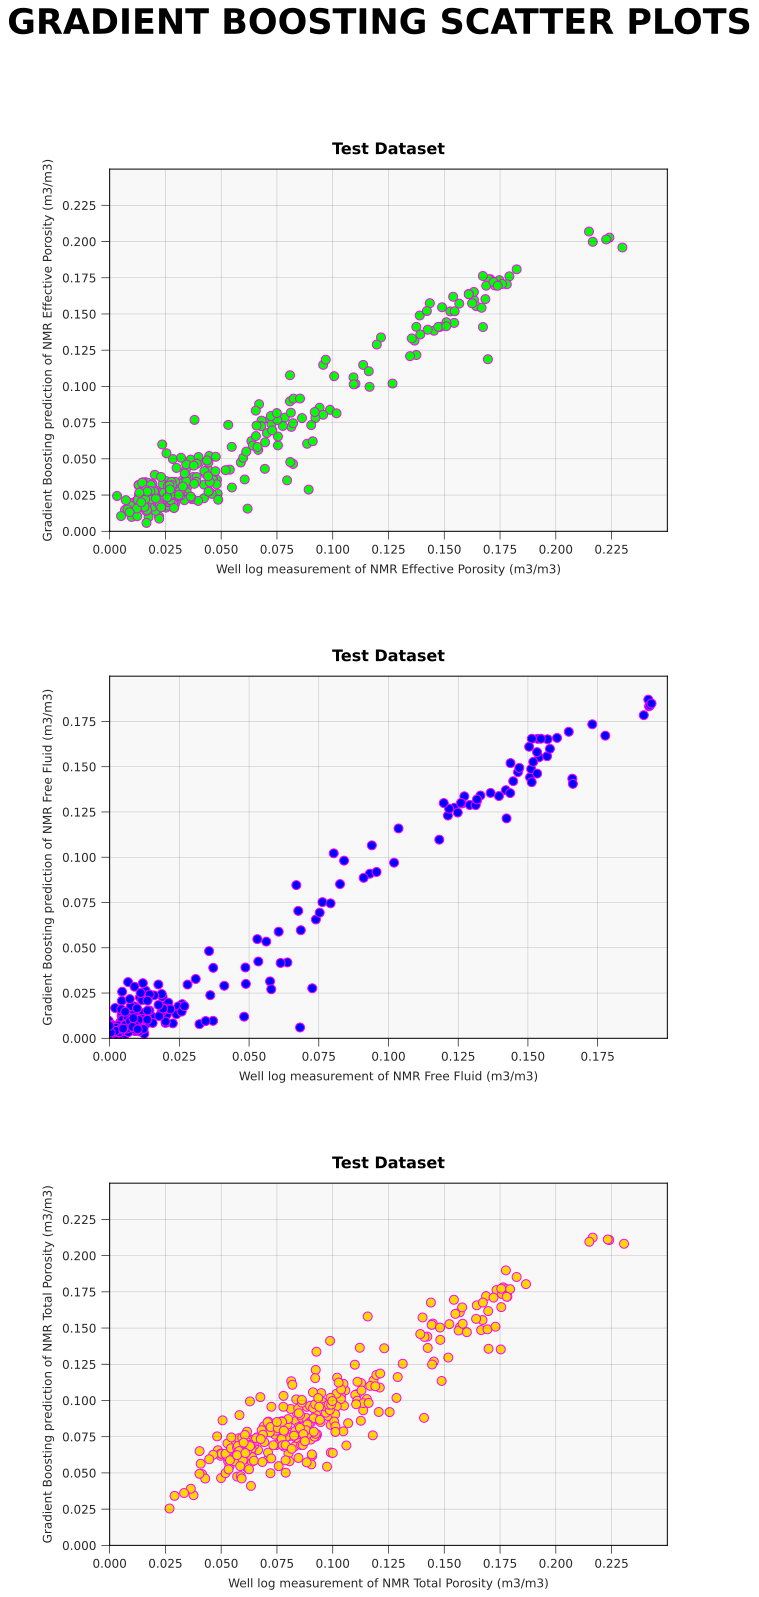

In [39]:
# Gradient Boosting Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("GRADIENT BOOSTING SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_test_out1,y_pred_out1_gb, s=80, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Gradient Boosting prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax1.set_xlim(0,0.25)
ax1.set_ylim(0,0.25)
ax1.set_xticks(np.arange(0, 0.25, 0.025))
ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Second Scatter Plot
ax2.scatter(y_test_out2,y_pred_out2_gb, s=80, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Gradient Boosting prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax2.set_xlim(0,0.200)
ax2.set_ylim(0,0.200)
ax2.set_xticks(np.arange(0, 0.200, 0.025))
ax2.set_yticks(np.arange(0, 0.200, 0.025))

# Third Scatter Plot 
ax3.scatter(y_test_out3,y_pred_out3_gb, s=80, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Gradient Boosting prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Test Dataset', fontsize=16, fontweight='bold')
ax3.set_xlim(0,0.25)
ax3.set_ylim(0,0.25)
ax3.set_xticks(np.arange(0, 0.25, 0.025))
ax3.set_yticks(np.arange(0, 0.25, 0.025))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

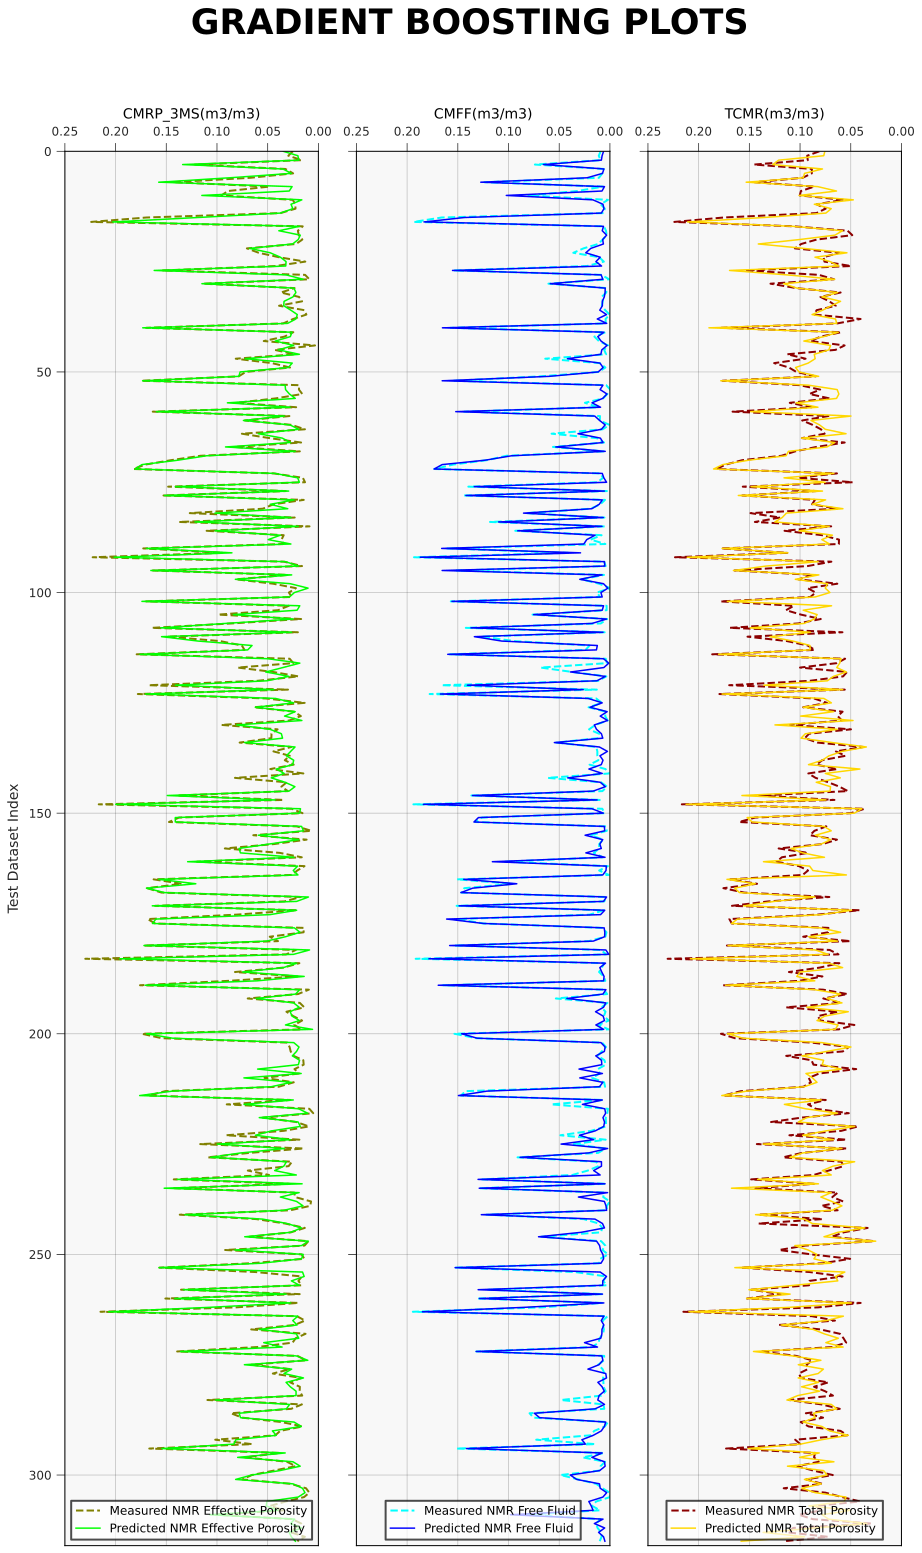

In [40]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,25))
fig.suptitle("GRADIENT BOOSTING PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.15)

#Set up the subplots grid
ax1 = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,3),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,3),(0,2),rowspan=1,colspan=1) 

x_ax = range(len(X_test))


# First Plot
ax1.plot(y_test_out1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_pred_out1_gb, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Test Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_test_out2_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_pred_out2_gb, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_test_out3_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_pred_out3_gb, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Set xlim() and ylim()
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(316,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.7)
    
# Hide tick labels on the y-axis
for ax in [ax2,ax3]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

<span style='color:crimson'> <span style="font-size:19px;"> **Performance Regression/Evaluation Metrics**

Beside the "Accuracy score" which, in this case, is the "Coefficient of Determination (r2)", we can assess the goodness of fit of the models with the following Regression Metrics, by considering only the Test Dataset:

**RANDOM FOREST MODEL**

In [41]:
# List of variables 
test_data = [y_test_out1_, y_test_out2_, y_test_out3_]
predicted_data = [y_pred_out1_rf, y_pred_out2_rf, y_pred_out3_rf]


# Create "for loop" that calculates the Regression Metrics for each variable, separately
def regression_metrics_rf():
    for i in range(len(test_data)):
        
        r2 = r2_score(test_data[i], predicted_data[i])
        r2 = round(r2,4)
        r2 = r2*100

        rmse = mean_squared_error(test_data[i], predicted_data[i], squared = False) # By default squared is True. If True returns MSE value, if False returns RMSE value
        rmse = round(rmse,4)
    
        mse = mean_squared_error(test_data[i], predicted_data[i], squared = True)
        mse = round(mse,4)
    
        mae = mean_absolute_error(test_data[i], predicted_data[i])
        mae = round(mae,4)
        
        print("Regression metrics for Variable", i+1)
        print("Coefficient of Determination:", r2)
        print("Root Mean Squared Error:", rmse)
        print("Mean Squared Error:", mse)
        print("Mean Absolute Error:", mae)
        print("="*90)

In [42]:
# Call function 
regression_metrics_rf()

Regression metrics for Variable 1
Coefficient of Determination: 94.63000000000001
Root Mean Squared Error: 0.0123
Mean Squared Error: 0.0002
Mean Absolute Error: 0.0083
Regression metrics for Variable 2
Coefficient of Determination: 97.24000000000001
Root Mean Squared Error: 0.0087
Mean Squared Error: 0.0001
Mean Absolute Error: 0.0051
Regression metrics for Variable 3
Coefficient of Determination: 88.56
Root Mean Squared Error: 0.0131
Mean Squared Error: 0.0002
Mean Absolute Error: 0.0099


**GRADIENT BOOSTING MODEL**

In [43]:
# List of variables 
test_data = [y_test_out1_, y_test_out2_, y_test_out3_]
predicted_data = [y_pred_out1_gb, y_pred_out2_gb, y_pred_out3_gb]


# Create "for loop" that calculates the Regression Metrics for each variable, separately
def regression_metrics_gb():
    for i in range(len(test_data)):
        
        r2 = r2_score(test_data[i], predicted_data[i])
        r2 = round(r2,4)
        r2 = r2*100
        
        rmse = mean_squared_error(test_data[i], predicted_data[i], squared = False) # By default squared is True. If True returns MSE value, if False returns RMSE value
        rmse = round(rmse,4)
    
        mse = mean_squared_error(test_data[i], predicted_data[i], squared = True)
        mse = round(mse,4)
    
        mae = mean_absolute_error(test_data[i], predicted_data[i])
        mae = round(mae,4)
        
        print("Regression metrics for Variable", i+1)
        print("Coefficient of Determination:", r2)
        print("Root Mean Squared Error:", rmse)
        print("Mean Squared Error:", mse)
        print("Mean Absolute Error:", mae)
        print("="*90)

In [44]:
# Call function 
regression_metrics_gb()

Regression metrics for Variable 1
Coefficient of Determination: 94.54
Root Mean Squared Error: 0.0124
Mean Squared Error: 0.0002
Mean Absolute Error: 0.0089
Regression metrics for Variable 2
Coefficient of Determination: 97.11
Root Mean Squared Error: 0.0089
Mean Squared Error: 0.0001
Mean Absolute Error: 0.0055
Regression metrics for Variable 3
Coefficient of Determination: 85.27
Root Mean Squared Error: 0.0148
Mean Squared Error: 0.0002
Mean Absolute Error: 0.0112


We can realize **histograms of Regression/Evaluation Metrics** to visualize the performance of the two models. 

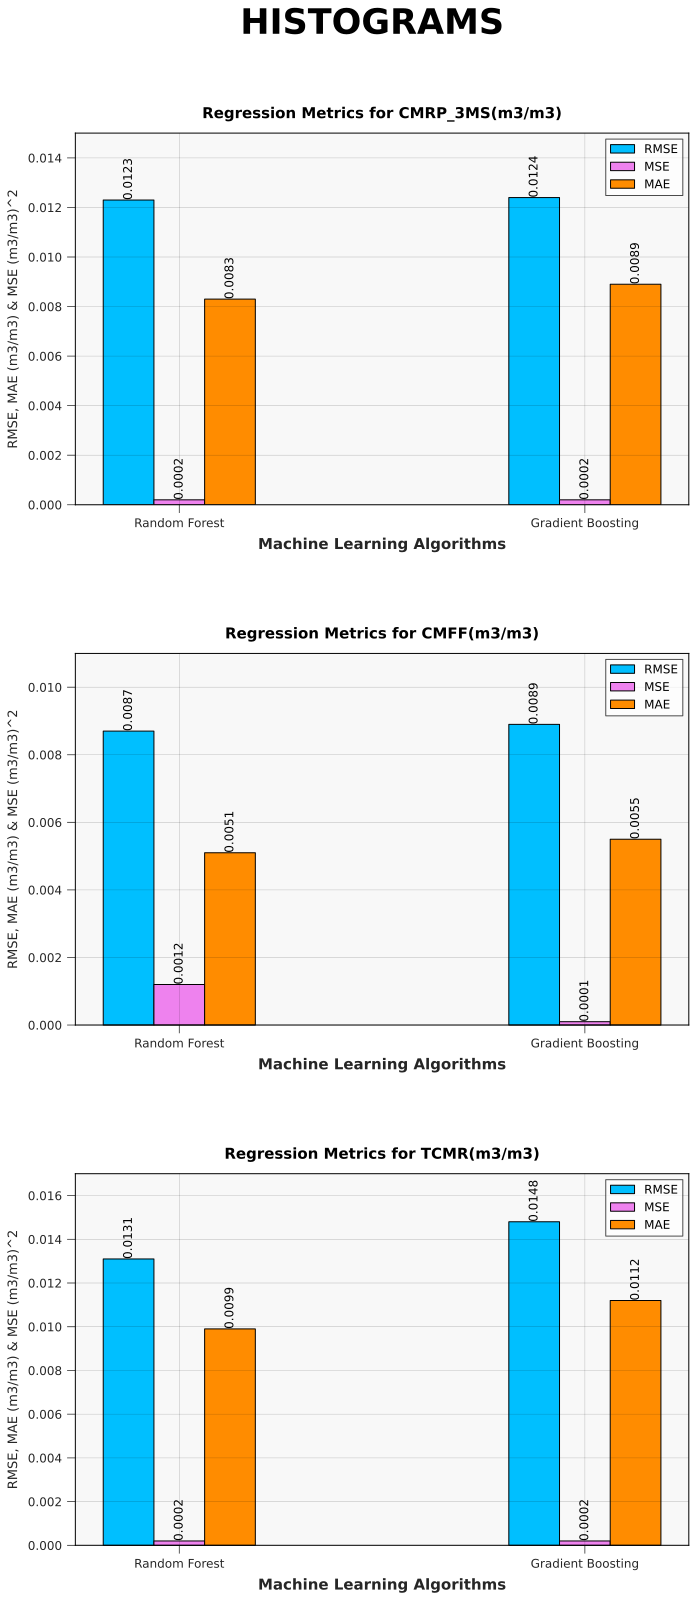

In [45]:
# Histograms 
fig, ax = plt.subplots(3,1, figsize=(11,25))
fig.suptitle("HISTOGRAMS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.91,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 

##############################################################################################################

# Histogram for Variable 1
models1 = ['Random Forest', 'Gradient Boosting']
metrics1 = ['RMSE','MSE','MAE']
RMSE1 = [0.0123, 0.0124]   # The unit is: [m3/m3]
MSE1 = [0.0002, 0.0002]    # The unit is: [m3/m3]^2
MAE1 = [0.0083, 0.0089]    # The unit is [m3/m3]

x1 = np.arange(len(models1))  # the label locations

ax1.bar(x1-0.125, RMSE1, width=0.125, color = 'deepskyblue', edgecolor='black')
ax1.bar(x1+0,     MSE1,  width=0.125, color = 'violet'     , edgecolor='black')
ax1.bar(x1+0.125, MAE1,  width=0.125, color = 'darkorange' , edgecolor='black')

ax1.annotate('0.0123', xy=(-0.125,0.0123), ha='center', va='bottom', rotation=90, fontsize=12)
ax1.annotate('0.0002', xy=(+0,0.0002),     ha='center', va='bottom', rotation=90, fontsize=12)
ax1.annotate('0.0083', xy=(+0.125,0.0083), ha='center', va='bottom', rotation=90, fontsize=12)

ax1.annotate('0.0124', xy=(0.875,0.0124), ha='center', va='bottom', rotation=90, fontsize=12)
ax1.annotate('0.0002', xy=(1,0.0002),     ha='center', va='bottom', rotation=90, fontsize=12)
ax1.annotate('0.0089', xy=(1.125,0.0089), ha='center', va='bottom', rotation=90, fontsize=12)

ax1.set_title('Regression Metrics for CMRP_3MS(m3/m3)', fontsize=15, fontweight='bold')
ax1.set_xticks(x1,models1, fontsize=13)
ax1.set_ylim(0,0.015)
ax1.legend(metrics1, fontsize='large', framealpha=0.7)

##############################################################################################################

# Histogram for Variable 2
models2 = ['Random Forest', 'Gradient Boosting']
metrics2 = ['RMSE','MSE','MAE']
RMSE2 = [0.0087, 0.0089]   # The unit is: [m3/m3]
MSE2 = [0.0012, 0.0001]    # The unit is: [m3/m3]^2
MAE2 = [0.0051, 0.0055]    # The unit is [m3/m3]

x2 = np.arange(len(models))  # the label locations

ax2.bar(x2-0.125, RMSE2, width=0.125, color = 'deepskyblue', edgecolor='black')
ax2.bar(x2+0,     MSE2,  width=0.125, color = 'violet'     , edgecolor='black')
ax2.bar(x2+0.125, MAE2,  width=0.125, color = 'darkorange' , edgecolor='black')

ax2.annotate('0.0087', xy=(-0.125,0.0087), ha='center', va='bottom', rotation=90, fontsize=12)
ax2.annotate('0.0012', xy=(+0,0.0012),     ha='center', va='bottom', rotation=90, fontsize=12)
ax2.annotate('0.0051', xy=(+0.125,0.0051), ha='center', va='bottom', rotation=90, fontsize=12)

ax2.annotate('0.0089', xy=(0.875,0.0089),  ha='center', va='bottom', rotation=90, fontsize=12)
ax2.annotate('0.0001', xy=(1,0.0001),      ha='center', va='bottom', rotation=90, fontsize=12)
ax2.annotate('0.0055', xy=(1.125,0.0055),  ha='center', va='bottom', rotation=90, fontsize=12)

ax2.set_title('Regression Metrics for CMFF(m3/m3)', fontsize=15, fontweight='bold')
ax2.set_xticks(x2,models2, fontsize=13)
ax2.set_ylim(0,0.011)
ax2.legend(metrics2, fontsize='large', framealpha=0.7)

##############################################################################################################

# Histogram for Variables 3 
models3 = ['Random Forest', 'Gradient Boosting']
metrics3 = ['RMSE','MSE','MAE']
RMSE3 = [0.0131, 0.0148]   # The unit is: [m3/m3]
MSE3 = [0.0002, 0.0002]    # The unit is: [m3/m3]
MAE3 = [0.0099, 0.0112]    # The unit is [m3/m3]

x3 = np.arange(len(models))  # the label locations

ax3.bar(x3-0.125, RMSE3, width=0.125, color = 'deepskyblue', edgecolor='black')
ax3.bar(x3+0,     MSE3,  width=0.125, color = 'violet'     , edgecolor='black')
ax3.bar(x3+0.125, MAE3,  width=0.125, color = 'darkorange' , edgecolor='black')

ax3.annotate('0.0131', xy=(-0.125,0.0131), ha='center', va='bottom', rotation=90, fontsize=12)
ax3.annotate('0.0002', xy=(+0,0.0002),     ha='center', va='bottom', rotation=90, fontsize=12)
ax3.annotate('0.0099', xy=(+0.125,0.0099), ha='center', va='bottom', rotation=90, fontsize=12)

ax3.annotate('0.0148', xy=(0.875,0.0148), ha='center', va='bottom', rotation=90, fontsize=12)
ax3.annotate('0.0002', xy=(1,0.0002),     ha='center', va='bottom', rotation=90, fontsize=12)
ax3.annotate('0.0112', xy=(1.125,0.0112), ha='center', va='bottom', rotation=90, fontsize=12)

ax3.set_title('Regression Metrics for TCMR(m3/m3)', fontsize=15, fontweight='bold')
ax3.set_xticks(x3,models3, fontsize=13)
ax3.set_ylim(0,0.017)
ax3.legend(metrics3, fontsize='large', framealpha=0.7)

##############################################################################################################

# For loop
for ax in [ax1,ax2,ax3]:
    
    # Add a black border to each subplot
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
    # Set font size of the tick labels
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Set grid 
    ax.grid(color='black',lw=0.5)

    # Set labels 
    ax.set_xlabel("Machine Learning Algorithms", fontweight='bold', fontsize=15)
    ax.set_ylabel("RMSE, MAE (m3/m3) & MSE (m3/m3)^2", fontsize=13)

<span style='color:crimson'> <span style="font-size:19px;"> **Selection of the Best Model**

We can conclude that "for this specific Dataset, the best model is: **Random Forest**". This is because it has higher accuracy and lower error.

<span style='color:crimson'> <span style="font-size:19px;"> **Feature Importance**

It is also possible to determine the most important "predictor", for each model and for each output, thanks to the "feature_importances" variable. 

**RANDOM FOREST MODEL**

In [46]:
features_rf_1 = np.round(rf_final_model.estimators_[0].feature_importances_,4)
features_rf_2 = np.round(rf_final_model.estimators_[1].feature_importances_,4)
features_rf_3 = np.round(rf_final_model.estimators_[2].feature_importances_,4)

In [47]:
# Print Features 
features_rf_1, features_rf_2, features_rf_3

(array([0.0233, 0.0163, 0.0252, 0.1727, 0.0858, 0.0143, 0.6624]),
 array([0.0865, 0.009 , 0.0181, 0.1211, 0.0577, 0.024 , 0.6837]),
 array([0.074 , 0.0102, 0.0154, 0.1165, 0.0708, 0.0221, 0.691 ]))

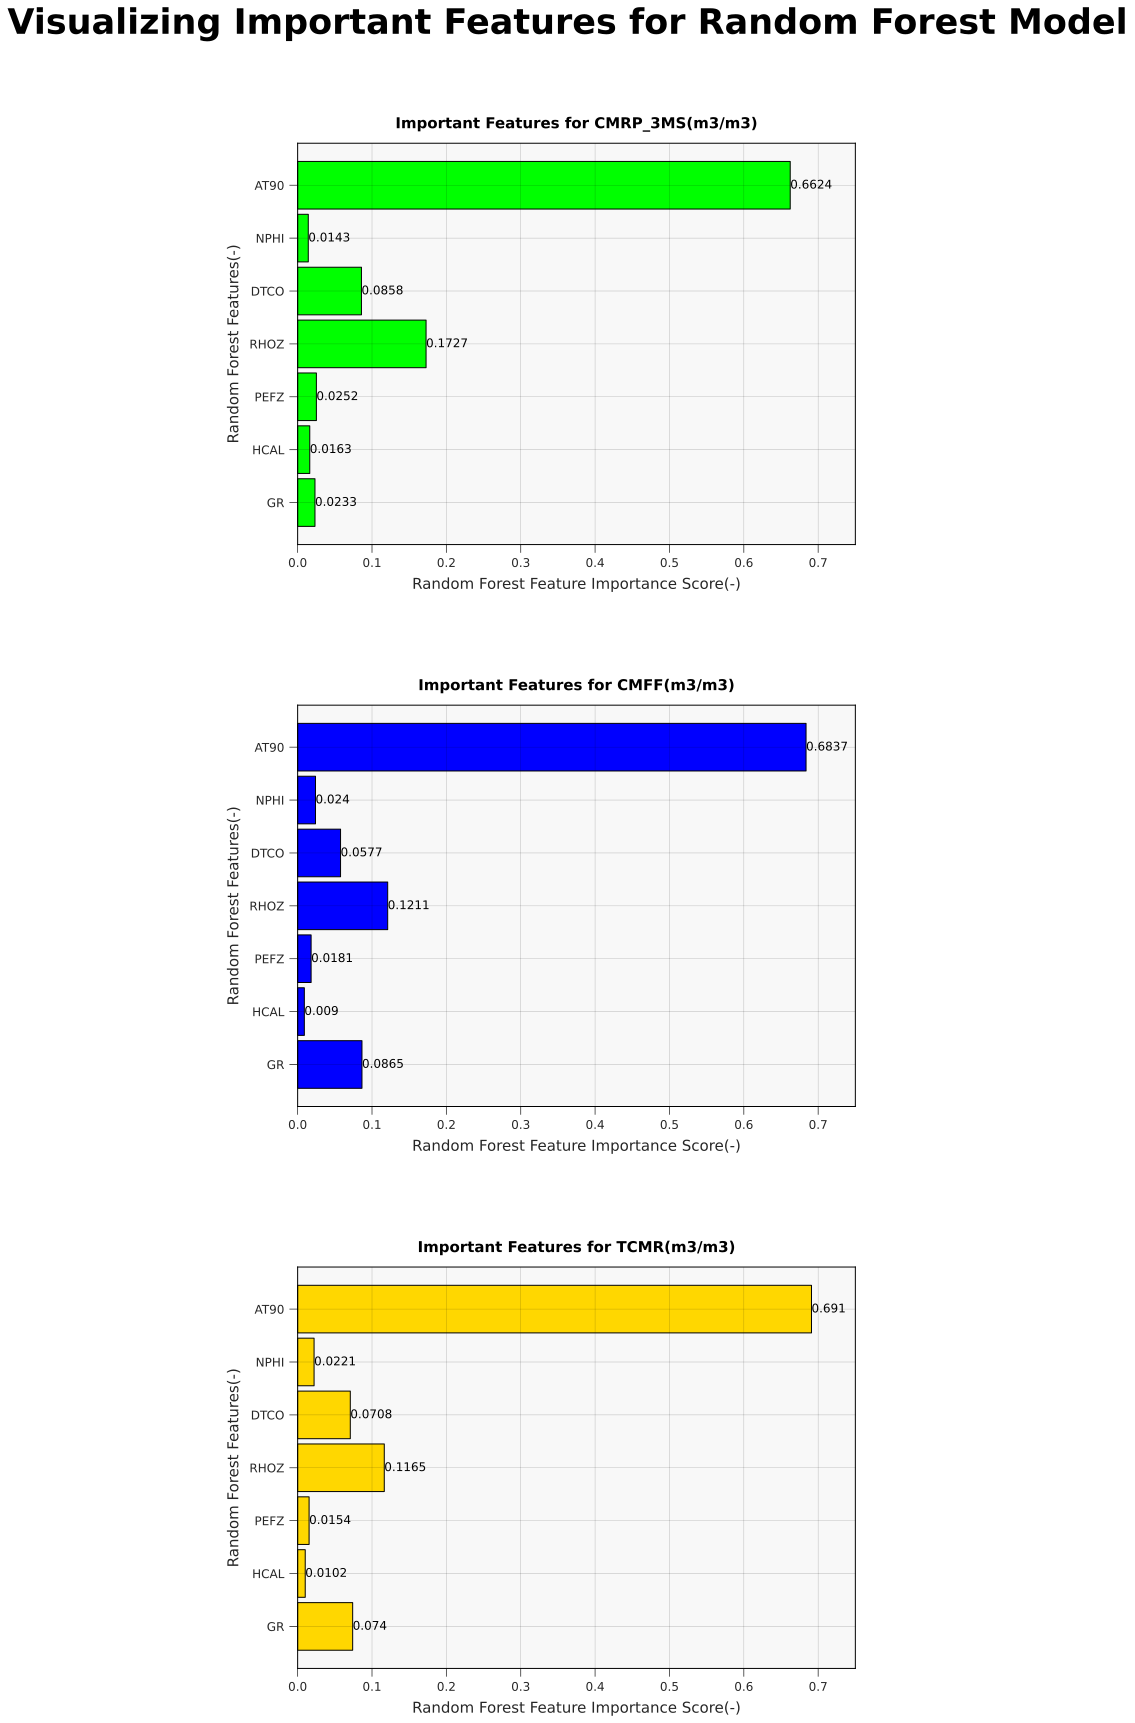

In [48]:
# Histograms 
fig, ax = plt.subplots(3,1, figsize=(10,27))
fig.suptitle('Visualizing Important Features for Random Forest Model', fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.91,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  

##############################################################################################################

# Histogram for Variable 1
ax1.barh(predictors, features_rf_1, color = 'lime', height=0.9, edgecolor='black')

ax1.annotate('0.0233', xy=(0.0233,'GR')  , ha='left', va='center', fontsize=12)
ax1.annotate('0.0163', xy=(0.0163,'HCAL'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0252', xy=(0.0252,'PEFZ'), ha='left', va='center', fontsize=12)
ax1.annotate('0.1727', xy=(0.1727,'RHOZ'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0858', xy=(0.0858,'DTCO'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0143', xy=(0.0143,'NPHI'), ha='left', va='center', fontsize=12)
ax1.annotate('0.6624', xy=(0.6624,'AT90'), ha='left', va='center', fontsize=12)

ax1.set_title('Important Features for CMRP_3MS(m3/m3)', fontsize=15, fontweight='bold')
ax1.set_xlim(0,0.75)

##############################################################################################################

# Histogram for Variable 2
ax2.barh(predictors, features_rf_2, color = 'blue', height=0.9, edgecolor='black')

ax2.annotate('0.0865', xy=(0.0865,'GR')  , ha='left', va='center', fontsize=12)
ax2.annotate('0.009' , xy=(0.009,'HCAL') , ha='left', va='center', fontsize=12)
ax2.annotate('0.0181', xy=(0.0181,'PEFZ'), ha='left', va='center', fontsize=12)
ax2.annotate('0.1211', xy=(0.1211,'RHOZ'), ha='left', va='center', fontsize=12)
ax2.annotate('0.0577', xy=(0.0577,'DTCO'), ha='left', va='center', fontsize=12)
ax2.annotate('0.024' , xy=(0.024,'NPHI') , ha='left', va='center', fontsize=12)
ax2.annotate('0.6837', xy=(0.6837,'AT90'), ha='left', va='center', fontsize=12)

ax2.set_title('Important Features for CMFF(m3/m3)', fontsize=15, fontweight='bold')
ax2.set_xlim(0,0.75)

##############################################################################################################

# Histogram for Variables 3 
ax3.barh(predictors, features_rf_3, color = 'gold', height=0.9, edgecolor='black')

ax3.annotate('0.074'  , xy=(0.074,'GR')    , ha='left', va='center', fontsize=12)
ax3.annotate('0.0102' , xy=(0.0102,'HCAL') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0154' , xy=(0.0154,'PEFZ') , ha='left', va='center', fontsize=12)
ax3.annotate('0.1165' , xy=(0.1165,'RHOZ') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0708' , xy=(0.0708,'DTCO') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0221' , xy=(0.0221,'NPHI') , ha='left', va='center', fontsize=12)
ax3.annotate('0.691'  , xy=(0.691,'AT90')  , ha='left', va='center', fontsize=12)

ax3.set_title('Important Features for TCMR(m3/m3)', fontsize=15, fontweight='bold')
ax3.set_xlim(0,0.75)

##############################################################################################################

# For loop
for ax in [ax1,ax2,ax3]:
    
    # Add a black border to each subplot
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
    # Set font size of the tick labels
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Set grid 
    ax.grid(color='black',lw=0.5)

    # Set labels
    ax.set_xlabel("Random Forest Feature Importance Score(-)", fontsize=15)
    ax.set_ylabel("Random Forest Features(-)", fontsize=15)


**GRADIENT BOOSTING MODEL**

In [49]:
features_gb_1 = np.round(gb_final_model.estimators_[0].feature_importances_,4)
features_gb_2 = np.round(gb_final_model.estimators_[1].feature_importances_,4)
features_gb_3 = np.round(gb_final_model.estimators_[2].feature_importances_,4)

In [50]:
# Print Features 
features_gb_1, features_gb_2, features_gb_3

(array([0.0682, 0.0169, 0.0303, 0.1522, 0.0405, 0.0141, 0.6779]),
 array([0.0121, 0.006 , 0.0355, 0.1274, 0.0133, 0.0101, 0.7956]),
 array([0.0302, 0.0219, 0.0349, 0.739 , 0.0348, 0.0709, 0.0683]))

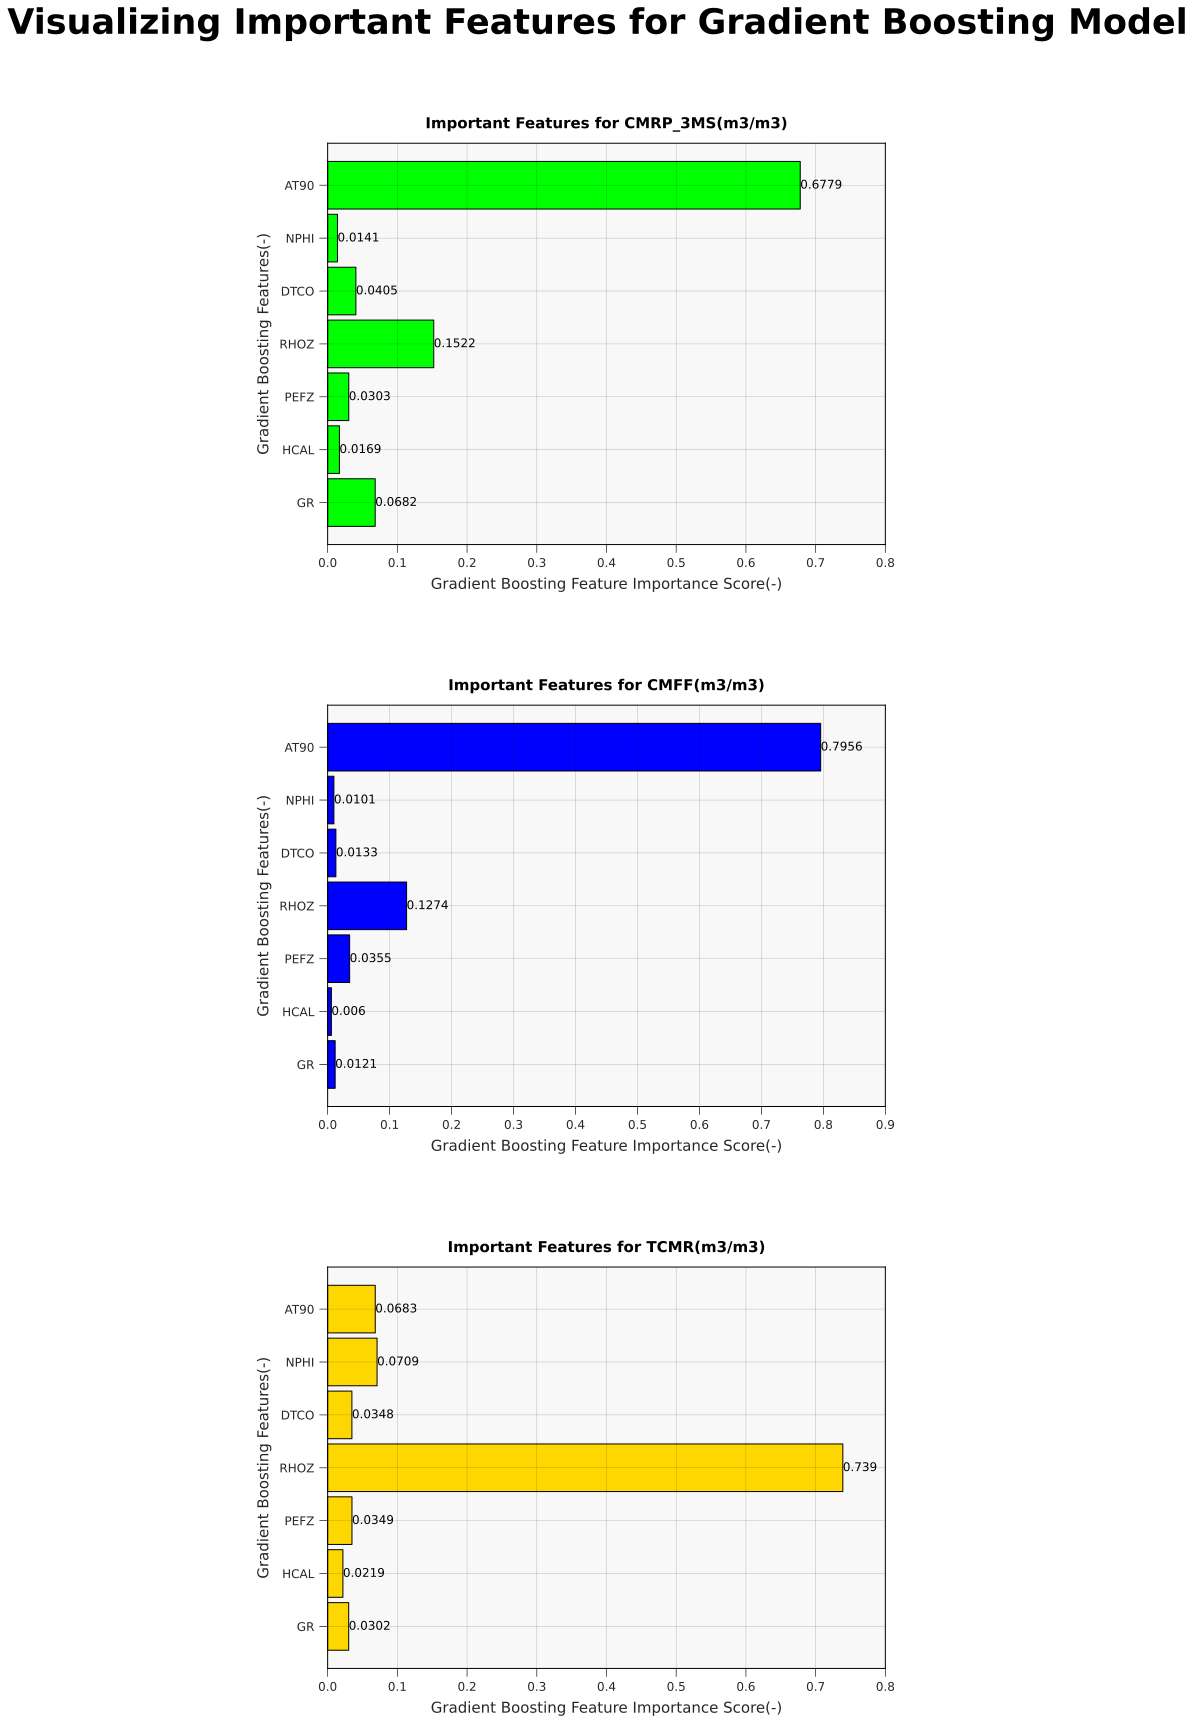

In [51]:
# Histograms 
fig, ax = plt.subplots(3,1, figsize=(10,27))
fig.suptitle('Visualizing Important Features for Gradient Boosting Model', fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.91,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  

##############################################################################################################

# Histogram for Variable 1
ax1.barh(predictors, features_gb_1, color = 'lime', height=0.9, edgecolor='black')

ax1.annotate('0.0682', xy=(0.0682,'GR')  , ha='left', va='center', fontsize=12)
ax1.annotate('0.0169', xy=(0.0169,'HCAL'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0303', xy=(0.0303,'PEFZ'), ha='left', va='center', fontsize=12)
ax1.annotate('0.1522', xy=(0.1522,'RHOZ'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0405', xy=(0.0405,'DTCO'), ha='left', va='center', fontsize=12)
ax1.annotate('0.0141', xy=(0.0141,'NPHI'), ha='left', va='center', fontsize=12)
ax1.annotate('0.6779', xy=(0.6779,'AT90'), ha='left', va='center', fontsize=12)

ax1.set_title('Important Features for CMRP_3MS(m3/m3)', fontsize=15, fontweight='bold')
ax1.set_xlim(0,0.8)

##############################################################################################################

# Histogram for Variable 2
ax2.barh(predictors, features_gb_2, color = 'blue', height=0.9, edgecolor='black')

ax2.annotate('0.0121', xy=(0.0121,'GR')  , ha='left', va='center', fontsize=12)
ax2.annotate('0.006' , xy=(0.006 ,'HCAL'), ha='left', va='center', fontsize=12)
ax2.annotate('0.0355', xy=(0.0355,'PEFZ'), ha='left', va='center', fontsize=12)
ax2.annotate('0.1274', xy=(0.1274,'RHOZ'), ha='left', va='center', fontsize=12)
ax2.annotate('0.0133', xy=(0.0133,'DTCO'), ha='left', va='center', fontsize=12)
ax2.annotate('0.0101', xy=(0.0101,'NPHI'), ha='left', va='center', fontsize=12)
ax2.annotate('0.7956', xy=(0.7956,'AT90'), ha='left', va='center', fontsize=12)

ax2.set_title('Important Features for CMFF(m3/m3)', fontsize=15, fontweight='bold')
ax2.set_xlim(0,0.9)

##############################################################################################################

# Histogram for Variables 3 
ax3.barh(predictors, features_gb_3, color = 'gold', height=0.9, edgecolor='black')

ax3.annotate('0.0302' , xy=(0.0302,'GR')   , ha='left', va='center', fontsize=12)
ax3.annotate('0.0219' , xy=(0.0219,'HCAL') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0349' , xy=(0.0349,'PEFZ') , ha='left', va='center', fontsize=12)
ax3.annotate('0.739'  , xy=(0.739 ,'RHOZ') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0348' , xy=(0.0348,'DTCO') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0709' , xy=(0.0709,'NPHI') , ha='left', va='center', fontsize=12)
ax3.annotate('0.0683' , xy=(0.0683,'AT90')  , ha='left', va='center', fontsize=12)

ax3.set_title('Important Features for TCMR(m3/m3)', fontsize=15, fontweight='bold')
ax3.set_xlim(0,0.8)

##############################################################################################################

# For loop
for ax in [ax1,ax2,ax3]:
    
    # Add a black border to each subplot
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
    # Set font size of the tick labels
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Set grid 
    ax.grid(color='black',lw=0.5)

    # Set labels
    ax.set_xlabel("Gradient Boosting Feature Importance Score(-)", fontsize=15)
    ax.set_ylabel("Gradient Boosting Features(-)", fontsize=15)

<span style='color:crimson'> <span style="font-size:19px;"> **Decision/Regression Tree Visualization for the Random Forest**

In [52]:
# Importing dependencies 
from sklearn import tree

In [53]:
# See all the decision trees we use the "estimators_" attribute 
rf_final_model.estimators_ # To see all the decision trees 

[DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=1608637542),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=1273642419),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=1935803228),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=787846414),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=996406378),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=1201263687),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=423734972),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=415968276),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=670094950),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=1914837113),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=669991378),
 DecisionTreeRegressor(max_depth=20, max_features=1.0, random_state=429389014),
 DecisionTreeRegressor(max_depth=20

In [54]:
 # See the total number of decision trees
len(rf_final_model.estimators_) 

400

In [ ]:
# Visualize the first decision tree (do not run this line because it will take too much time)
plt.figure(figsize=(11,11))
tree.plot_tree(rf_final_model.estimators_[0],filled=False) # [0] is the Index

Thanks to the "tree.plot_tree" function, it is possible to visualize the decision process that is occurring in the algorithm.

To understand the "Decision Tree Structure" see this link: 
"https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py".

Additional info:
1. At the "leaf nodes" we have the prediction outcomes;
2. The variables, for each node, are chosen randomly by the algorithm. Note: X[6], 6 is the index and, thus, we are talking about the last predictor which is AT90;
3. The darker is the node and the lower is the error for that prediction.

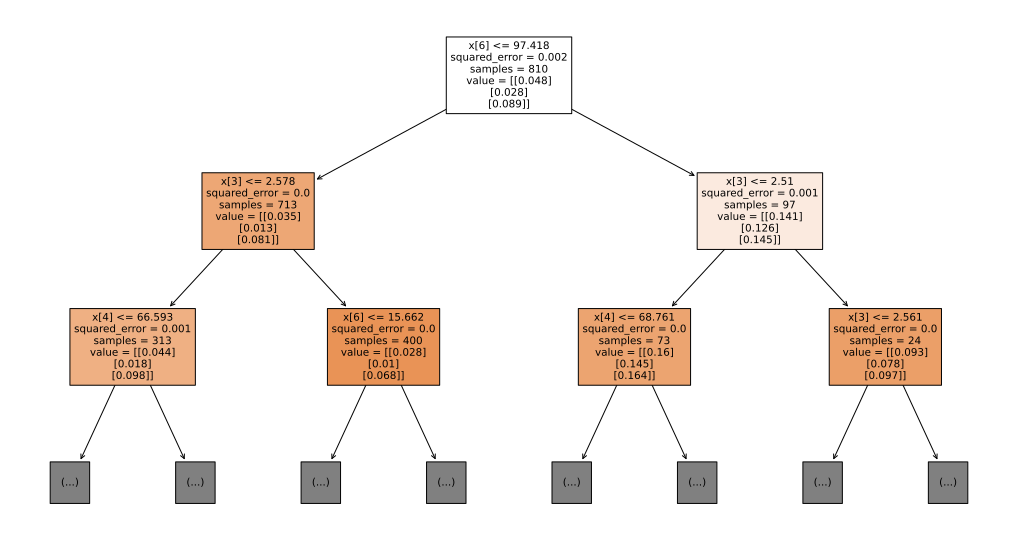

In [55]:
plt.figure(figsize=(18,10)) 

# Make the visualization readable, it is necessary to limit the depth of the Decision Tree.
tree.plot_tree(rf_final_model.estimators_[0], max_depth=2, filled=True);

In [ ]:
# To visualize all the trees we write a for loop (do not run this line because it will take too much time)
plt.figure(figsize=(11,11))
#for i in range(len(rf_final_model.estimators_)):
    tree.plot_tree(rf_final_model.estimators_[i], max_depth=2, filled=True, rounded=True)
    plt.savefig('fig'+str(i))
    plt.show()

<span style='color:crimson'> <span style="font-size:19px;"> **Save and Load the Random Forest & Gradient Boosting Models**

After training the Machine Learning Models, we need to save them for future use (future predictions). 

We use the "pickle" library thats allows to save and load the ML models. 

In [56]:
import pickle  # Library for save and load scikit-learn models

**RANDOM FOREST MODEL**

In [57]:
# Define file name. ".pickle" as file extension. A pickle file is a binary file. 
filename = "random_forest.pickle"

# Save Random Forest Model by means of "pickle.dump" function to store the object data to the file. 
# This function takes 2 arguments:
# Object that you want to store.
# File object you get by opening the desired file in write-binary (wb) mode.
pickle.dump(rf_final_model, open(filename, "wb"))

# Load Random Forest Model by means of the "pickle.load" function.
# The primary argument of the function is the file object you get by opening the desired file in read-binary (rb) mode.
random_forest_model_loaded = pickle.load(open(filename, "rb")) 

In [58]:
# To print the trained and tuned random forest model 
print(random_forest_model_loaded)

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=42)


In [59]:
# You can use the loaded model to compute predictions
# We perform the prediction on the entire original dataset 

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  
outputs = ["CMRP_3MS","CMFF","TCMR"] 

X = df[predictors]
y = df[outputs]                                   

In [60]:
# New prediction on the entire dataset
y_predicted_rf = random_forest_model_loaded.predict(X)

In [61]:
# Extract the predicted values for output 1, output 2 and output 3
y_predicted_out1_rf = y_predicted_rf[:, 0]
y_predicted_out2_rf = y_predicted_rf[:, 1]
y_predicted_out3_rf = y_predicted_rf[:, 2]

In [62]:
# Extract output 1, output 2 and output 3
y_out1 = y.drop(columns=["CMFF","TCMR"])      # CMRP_3MS
y_out2 = y.drop(columns=["CMRP_3MS","TCMR"])  # CMFF
y_out3 = y.drop(columns=["CMRP_3MS","CMFF"])  # TCMR

**It is really important to verify that our predicted values have physical meaning.** 

Indeed we should satisfy the following condition: **NMR Total Porosity > NMR Effective Porosity > NMR Free Fluid**

In [63]:
# Define the 3 arrays 
array1 = y_predicted_out1_rf  # CMRP_3MS
array2 = y_predicted_out2_rf  # CMFF
array3 = y_predicted_out3_rf  # TCMR

In [64]:
# Write for loop
# The function "verify_values" compares the elements at each index. 
# The function returns True (the condition is satisfied) only if all the elements in array2 are lower than the elements in array1 and lower than the elements in array3
def verify_values(array1,array2,array3):
 
    for i in range(len(array1)):
        if array2[i] >= array1[i] >= array3[i]:
            return False
    
    return True

In [65]:
# Call function 
verify_values(array1,array2,array3)

True

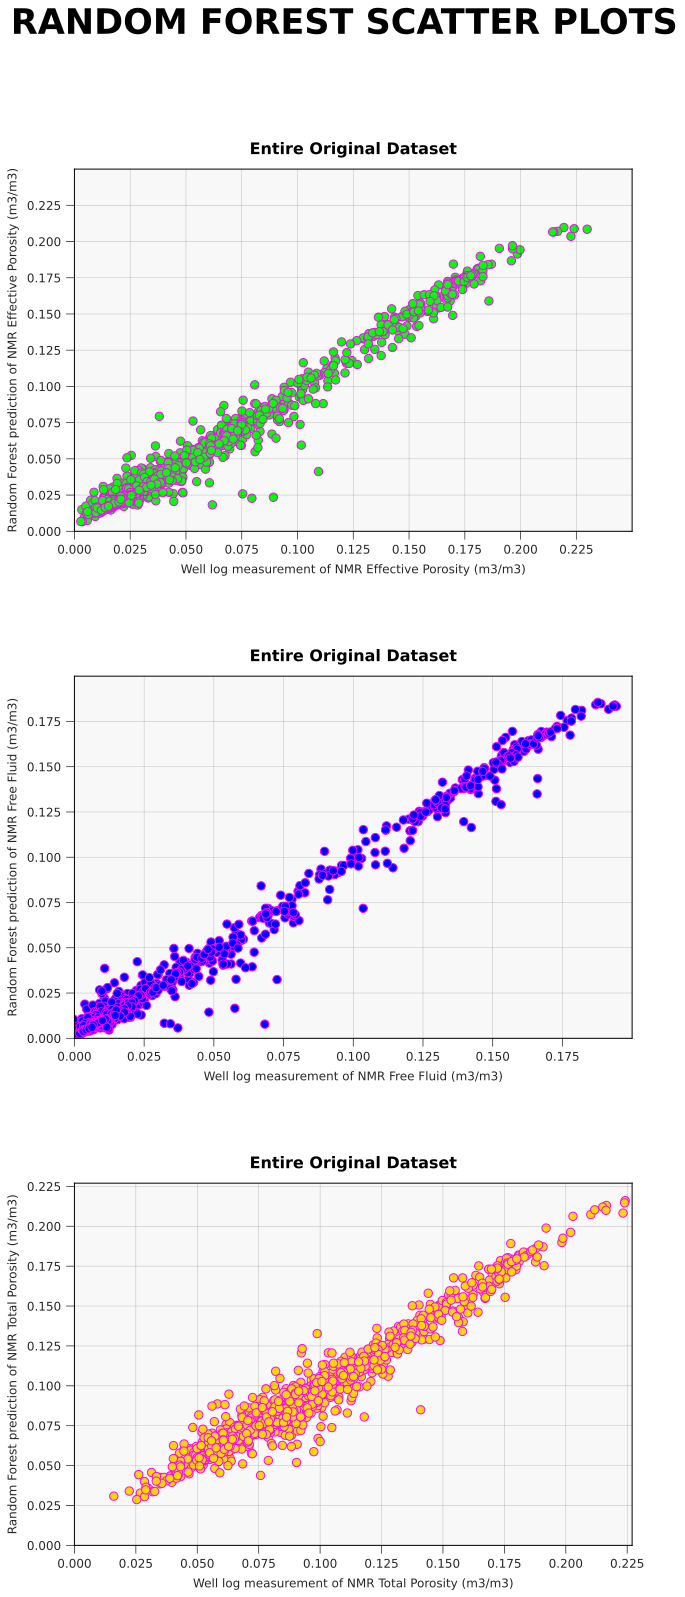

In [66]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("RANDOM FOREST SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_out1,y_predicted_out1_rf, s=70, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Random Forest prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax1.set_xlim(0,0.25)
ax1.set_ylim(0,0.25)
ax1.set_xticks(np.arange(0, 0.25, 0.025))
ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Second Scatter Plot
ax2.scatter(y_out2,y_predicted_out2_rf, s=70, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Random Forest prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax2.set_xlim(0,0.200)
ax2.set_ylim(0,0.200)
ax2.set_xticks(np.arange(0, 0.200, 0.025))
ax2.set_yticks(np.arange(0, 0.200, 0.025))

# Third Scatter Plot 
ax3.scatter(y_out3,y_predicted_out3_rf, s=70, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Random Forest prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax3.set_xlim(0,0.227)
ax3.set_ylim(0,0.227)
ax3.set_xticks(np.arange(0, 0.227, 0.025))
ax3.set_yticks(np.arange(0, 0.227, 0.025))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

In [67]:
# Otput 1, Output 2 and Output 3 should be converted into arrays 
y_out1_ = np.array(y_out1)
y_out2_ = np.array(y_out2)
y_out3_ = np.array(y_out3)

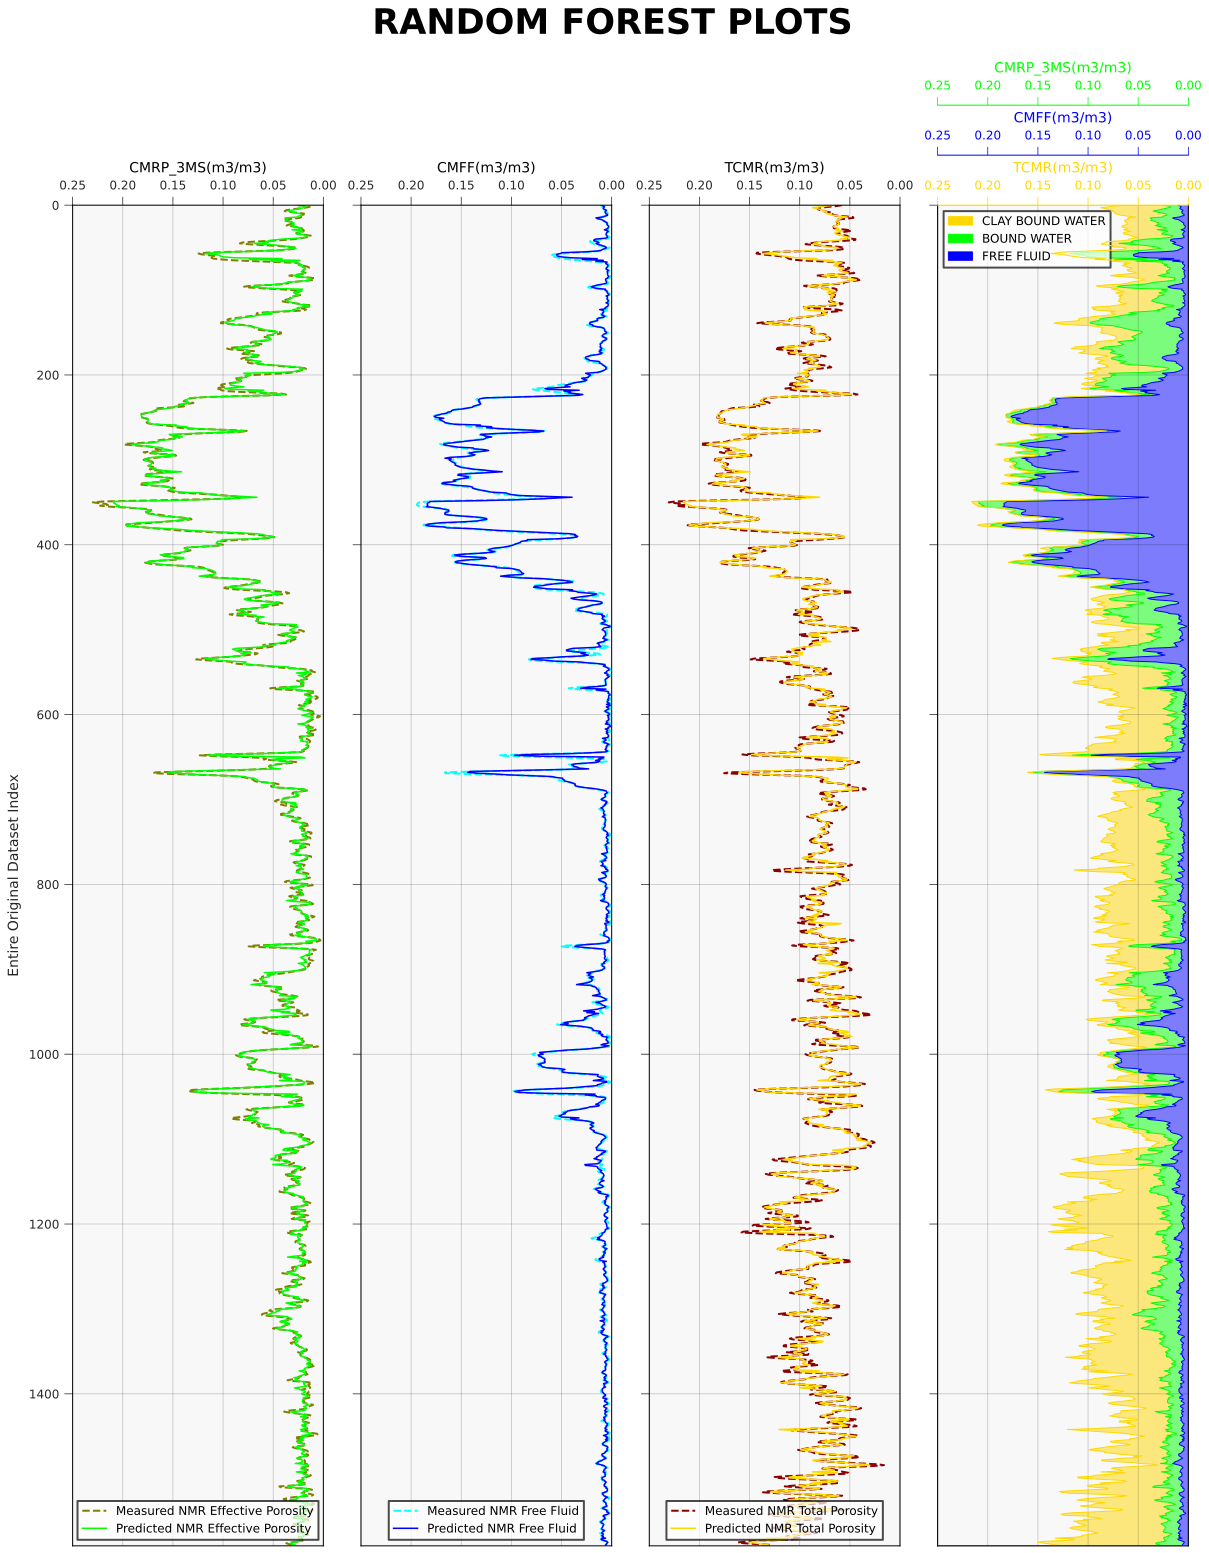

In [68]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,25))
fig.suptitle("RANDOM FOREST PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.87, wspace=0.15)


track_names = ['CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)','CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)']

#Set up the subplots grid
ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1) 
ax4 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1) 
ax5 = ax4.twiny()
ax6 = ax4.twiny()

x_ax = range(len(X))


##IMPORTANT NOTE: In this case, the "Entire Original Dataset Index" corresponds to the "Measured Depth (m)"

# First Plot
ax1.plot(y_out1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_predicted_out1_rf, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Entire Original Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_out2_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_predicted_out2_rf, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_out3_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_predicted_out3_rf, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Fourth Plot
ax4.plot(y_predicted_out1_rf, x_ax, color = "lime", lw = 1, linestyle = '-')                                                    
ax4.spines['top'].set_position(('outward',100))
ax4.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='lime') 
ax4.tick_params(axis='x', colors='lime', labelsize=12)
ax4.spines["top"].set_edgecolor("lime")

ax5.plot(y_predicted_out2_rf, x_ax, color = "blue", lw = 1, linestyle = '-' )
ax5.spines['top'].set_position(('outward',50))
ax5.set_xlabel('CMFF(m3/m3)', fontsize=14, color='blue') 
ax5.tick_params(axis='x', colors='blue', labelsize=12)
ax5.spines["top"].set_edgecolor("blue")

ax6.plot(y_predicted_out3_rf, x_ax, color = "gold", lw = 1, linestyle = '-' )                                                  
ax6.spines['top'].set_position(('outward',0))
ax6.set_xlabel('TCMR(m3/m3)', fontsize=14, color='gold')
ax6.tick_params(axis='x', colors='gold', labelsize=12)
ax6.spines["top"].set_edgecolor("gold")

# Add shading in Fifth Track with fill_betweenx(y, left handside value, x)
ax4.fill_betweenx(x_ax,y_predicted_out2_rf,0,                   facecolor='blue', alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out1_rf,y_predicted_out2_rf, facecolor='lime', alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out3_rf,y_predicted_out1_rf, facecolor='gold', alpha=0.5, interpolate=True)

# Create legend for Fifth Track 
Clay_Bound_Water = mpatches.Patch(color='gold', label='CLAY BOUND WATER')
Bound_Water      = mpatches.Patch(color='lime', label='BOUND WATER')
Free_Fluid       = mpatches.Patch(color='blue', label='FREE FLUID')
legend4 = ax4.legend(handles=[Clay_Bound_Water, Bound_Water, Free_Fluid], loc='upper left', fontsize='large', framealpha=0.7)



# Set xlim() and ylim()
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(1579,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
for ax in [ax6]:
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(color='black',lw=0.7)
for ax in [ax5,ax6]:
    ax.grid(visible=False)

# Hide tick labels on the y-axis
for ax in [ax2,ax3,ax4,ax5,ax6]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3,legend4]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

**GRADIENT BOOSTING MODEL**

In [69]:
# Define file name. ".pickle" as file extension.
filename = "gradient_boosting.pickle"

# Save Gradient Boosting Model by means of "pickle.dump" function to store the object data to the file. 
pickle.dump(gb_final_model, open(filename, "wb"))

# Load Gradient Boosting Model by means of the "pickle.load" function.
gradient_boosting_model_loaded = pickle.load(open(filename, "rb")) 

In [70]:
# Print the trained and tuned random forest model 
print(gradient_boosting_model_loaded)

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.3,
                                                         max_depth=5,
                                                         n_estimators=250,
                                                         random_state=42))


In [71]:
# You can use the loaded model to compute predictions
# We perform the prediction on the entire original dataset 

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  
outputs = ["CMRP_3MS","CMFF","TCMR"] 

X = df[predictors]
y = df[outputs]                                    

In [72]:
# New prediction on the entire dataset
y_predicted_gb = gradient_boosting_model_loaded.predict(X)

In [73]:
# Extract the predicted values for output 1, output 2 and output 3
y_predicted_out1_gb = y_predicted_gb[:, 0]
y_predicted_out2_gb = y_predicted_gb[:, 1]
y_predicted_out3_gb = y_predicted_gb[:, 2]

Also in this case, verify the following condition: **NMR Total Porosity > NMR Effective Porosity > NMR Free Fluid**

In [74]:
# Define the 3 arrays 
array1_ = y_predicted_out1_gb  # CMRP_3MS
array2_ = y_predicted_out2_gb  # CMFF
array3_ = y_predicted_out3_gb  # TCMR

In [75]:
# Write for loop
def verify_values(array1_,array2_,array3_):
 
    for i in range(len(array1_)):
        if array2_[i] >= array1_[i] >= array3_[i]:
            return False
    
    return True

In [76]:
# Call function 
verify_values(array1_,array2_,array3_)

False

**IMPORTANT COMMENT:** Our condition is not satisfied. Thus, we should apply **Post-Processing Rules** to the predictions of the model; this means that we can adjust the predictions based on specific conditions.

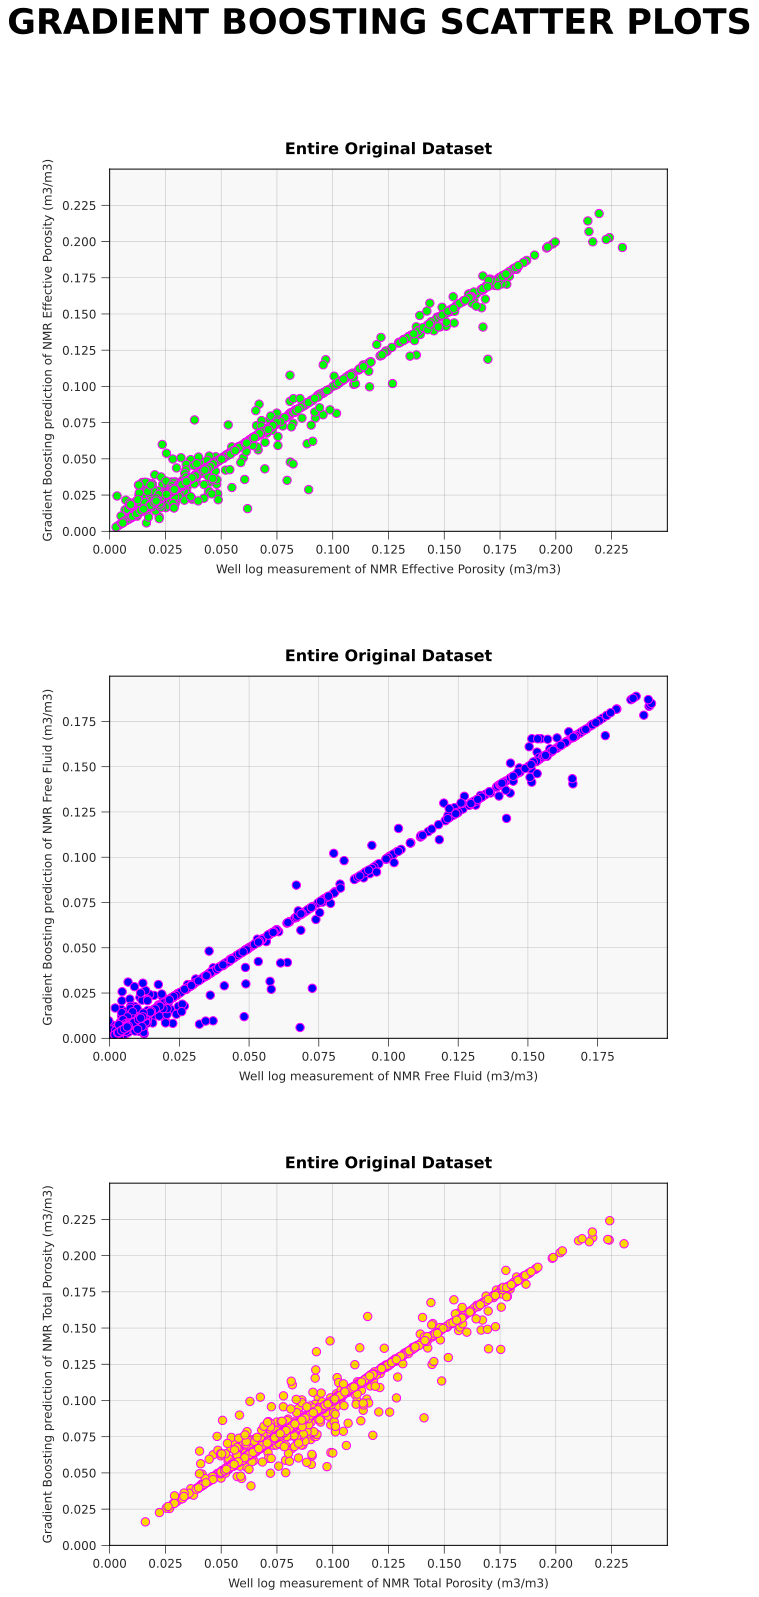

In [77]:
# Gradient Boosting Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("GRADIENT BOOSTING SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_out1,y_predicted_out1_gb, s=70, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Gradient Boosting prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax1.set_xlim(0,0.25)
ax1.set_ylim(0,0.25)
ax1.set_xticks(np.arange(0, 0.25, 0.025))
ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Second Scatter Plot
ax2.scatter(y_out2,y_predicted_out2_gb, s=70, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Gradient Boosting prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax2.set_xlim(0,0.200)
ax2.set_ylim(0,0.200)
ax2.set_xticks(np.arange(0, 0.200, 0.025))
ax2.set_yticks(np.arange(0, 0.200, 0.025))

# Third Scatter Plot 
ax3.scatter(y_out3,y_predicted_out3_gb, s=70, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Gradient Boosting prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
ax3.set_xlim(0,0.25)
ax3.set_ylim(0,0.25)
ax3.set_xticks(np.arange(0, 0.25, 0.025))
ax3.set_yticks(np.arange(0, 0.25, 0.025))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

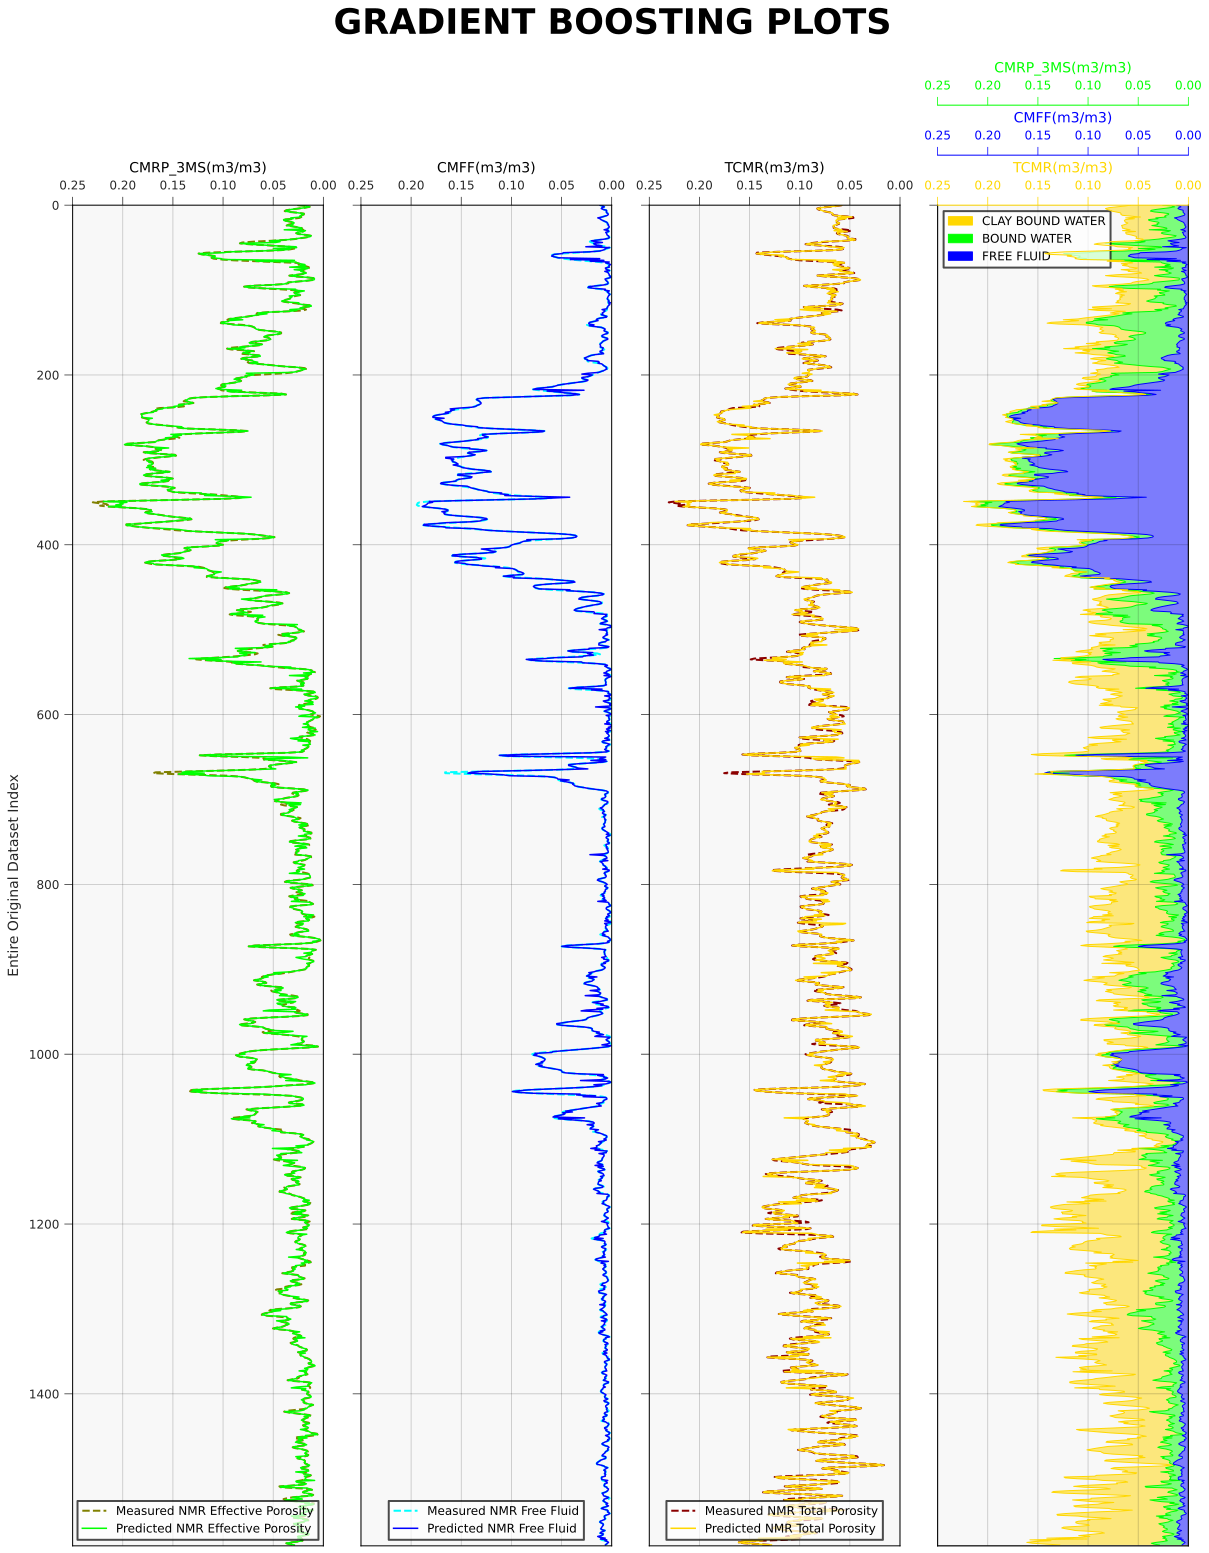

In [78]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,25))
fig.suptitle("GRADIENT BOOSTING PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.87, wspace=0.15)


track_names = ['CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)','CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)']

#Set up the subplots grid
ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1) 
ax4 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1) 
ax5 = ax4.twiny()
ax6 = ax4.twiny()

x_ax = range(len(X))


##IMPORTANT NOTE: In this case, the "Entire Original Dataset Index" corresponds to the "Measured Depth (m)"

# First Plot
ax1.plot(y_out1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_predicted_out1_gb, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Entire Original Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_out2_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_predicted_out2_gb, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_out3_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_predicted_out3_gb, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Fourth Plot
ax4.plot(y_predicted_out1_gb, x_ax, color = "lime", lw = 1, linestyle = '-')                                                    
ax4.spines['top'].set_position(('outward',100))
ax4.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='lime') 
ax4.tick_params(axis='x', colors='lime', labelsize=12)
ax4.spines["top"].set_edgecolor("lime")

ax5.plot(y_predicted_out2_gb, x_ax, color = "blue", lw = 1, linestyle = '-' )
ax5.spines['top'].set_position(('outward',50))
ax5.set_xlabel('CMFF(m3/m3)', fontsize=14, color='blue') 
ax5.tick_params(axis='x', colors='blue', labelsize=12)
ax5.spines["top"].set_edgecolor("blue")

ax6.plot(y_predicted_out3_gb, x_ax, color = "gold", lw = 1, linestyle = '-' )                                                  
ax6.spines['top'].set_position(('outward',0))
ax6.set_xlabel('TCMR(m3/m3)', fontsize=14, color='gold')
ax6.tick_params(axis='x', colors='gold', labelsize=12)
ax6.spines["top"].set_edgecolor("gold")

# Add shading in Fifth Track with fill_betweenx(y, left handside value, x)
ax4.fill_betweenx(x_ax,y_predicted_out2_gb,0,                   facecolor='blue', alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out1_gb,y_predicted_out2_gb, facecolor='lime',    alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out3_gb,y_predicted_out1_gb, facecolor='gold',    alpha=0.5, interpolate=True)

# Create legend for Fifth Track 
Clay_Bound_Water = mpatches.Patch(color='gold'   , label='CLAY BOUND WATER')
Bound_Water      = mpatches.Patch(color='lime'   , label='BOUND WATER')
Free_Fluid       = mpatches.Patch(color='blue', label='FREE FLUID')
legend4 = ax4.legend(handles=[Clay_Bound_Water, Bound_Water, Free_Fluid], loc='upper left', fontsize='large', framealpha=0.7)



# Set xlim() and ylim()
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(1579,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
for ax in [ax6]:
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(color='black',lw=0.7)
for ax in [ax5,ax6]:
    ax.grid(visible=False)

# Hide tick labels on the y-axis
for ax in [ax2,ax3,ax4,ax5,ax6]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3,legend4]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

<span style='color:crimson'> <span style="font-size:19px;"> **Applying the Saved ML Models to WELL 1-BRSA-1116-RJS**

In this case, we want to predict NMR Effective Porosity (CMRP_3MS), NMR Free Fluid (CMFF) and NMR Total Porosity (TCMR) for WELL 1-BRSA-1116-RJS, by applying the predictive machine learning models that have been trained and tuned on WELL 3-BRSA-1215-RJS.

In [79]:
# Load the csv well log data to Pandas DataFrame 
df1 = pd.read_csv("df_0_ML.csv")
df1

DEPTH         GR      HCAL        AT10         AT30         AT90  \
0     5360.0605  35.279163  8.515420  1016.64390   107.641785    15.770428   
1     5360.2130  30.944984  8.531169   368.53894    71.917170    14.622712   
2     5360.3650  30.891632  8.507545   151.82720    47.891834    13.278432   
3     5360.5176  33.754704  8.507545    75.00885    26.285194    10.144289   
4     5360.6700  34.204190  8.507545    69.59716    24.250814     8.864613   
...         ...        ...       ...         ...          ...          ...   
2277  5707.0750  11.873962  8.483921  1322.44560  1242.539400  1252.862700   
2278  5707.2275  11.425494  8.483921  1205.08460  1109.653400  1036.829700   
2279  5707.3800  13.846381  8.483921   956.74774  1235.044000  1385.859500   
2280  5707.5320  14.610580  8.483921   700.31460  1313.314300  1304.968400   
2281  5707.6850  18.009985  8.483921   705.08250  1338.367800  1334.417200   

          RHOZ      PEFZ      NPHI  CMRP_3MS      CMFF      TCMR       DTCO  \
0     2.452744  5.201865  0.208765  0.130692  0.089682  0.135796  64.758060   
1     2.448344  5.205754  0.214526  0.143868  0.105327  0.150145  65.928440   
2     2.446247  5.226230  0.222019  0.160956  0.125177  0.166302  66.844930   
3     2.445958  5.266283  0.229226  0.175774  0.142034  0.179409  67.698944   
4     2.445939  5.313303  0.232542  0.181463  0.151684  0.185023  68.012560   
...        ...       ...       ...       ...       ...       ...        ...   
2277  2.496519  5.203129  0.127375  0.042941  0.011153  0.049551  66.717070   
2278  2.511774  5.035268  0.129767  0.042941  0.011153  0.049551  67.105286   
2279  2.525568  4.876944  0.131832  0.042941  0.011153  0.049551  66.820100   
2280  2.538642  4.721669  0.130556  0.042941  0.011153  0.049551  66.465830   
2281  2.546279  4.594101  0.127143  0.042941  0.011153  0.049551  66.272830   

            DTSM  
0     115.268300  
1     116.395880  
2     120.521550  
3     121.989914  
4     123.254760  
...          ...  
2277  125.244300  
2278  126.993034  
2279  126.357810  
2280  126.107605  
2281  125.546060  

[2282 rows x 14 columns]

**RANDOM FOREST MODEL**

In [80]:
# Load the trained and tuned Random Forest Model 
RandomForestModel = pd.read_pickle('random_forest.pickle')

In [81]:
# Print the Model 
RandomForestModel

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=42)

In [82]:
# Compute new predictions by using the "unseen data" of WELL 1-BRSA-1116-RJS

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  
outputs = ["CMRP_3MS","CMFF","TCMR"]  # They are predicted at the same time 

X = df1[predictors]
y = df1[outputs]

In [83]:
# New prediction on the entire dataset
y_predicted_rf1 = RandomForestModel.predict(X)

In [84]:
# Extract the predicted values for output 1, output 2 and output 3
y_predicted_out1_rf1 = y_predicted_rf1[:, 0]
y_predicted_out2_rf1 = y_predicted_rf1[:, 1]
y_predicted_out3_rf1 = y_predicted_rf1[:, 2]

In [85]:
# Extract output 1, output 2 and output 3
y_out1_1 = y.drop(columns=["CMFF","TCMR"])      # CMRP_3MS
y_out2_1 = y.drop(columns=["CMRP_3MS","TCMR"])  # CMFF
y_out3_1 = y.drop(columns=["CMRP_3MS","CMFF"])  # TCMR

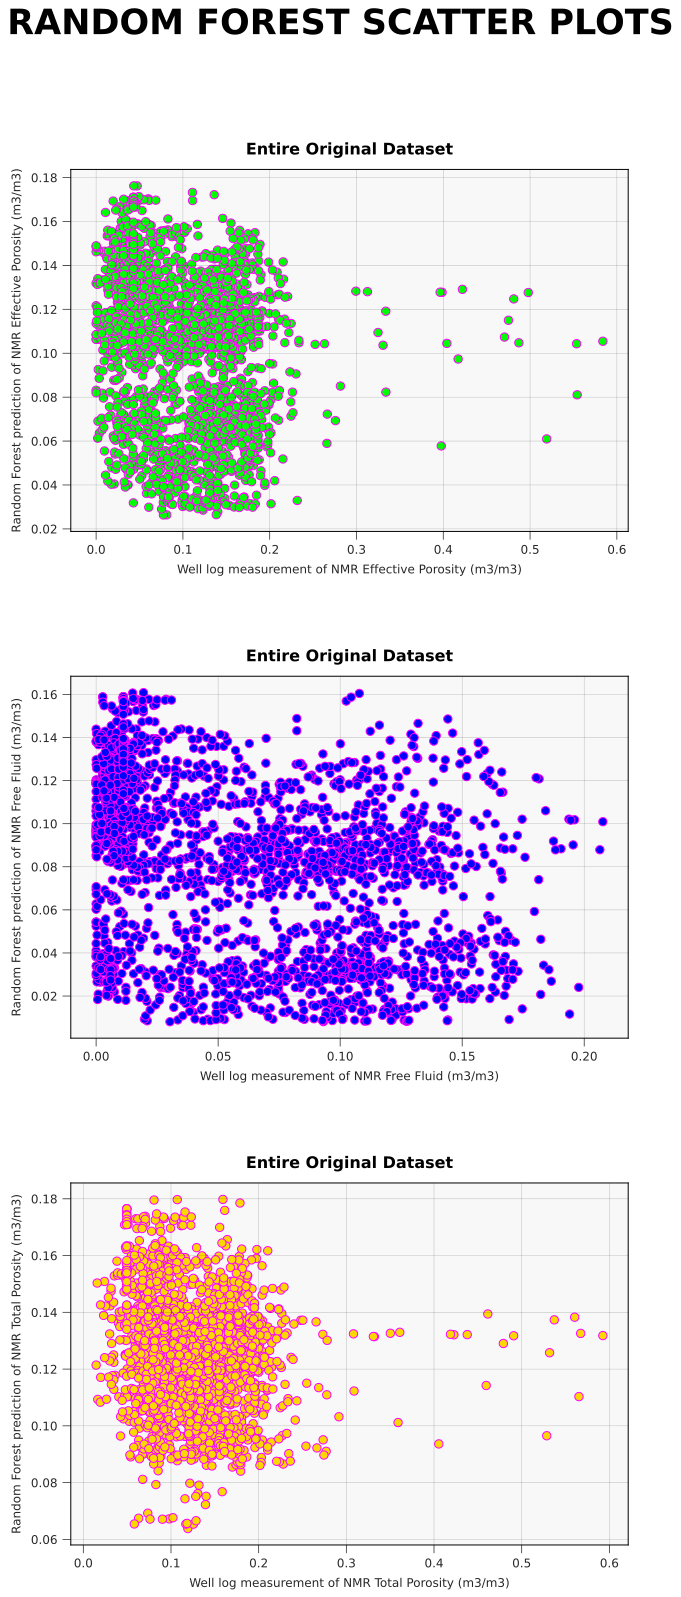

In [86]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("RANDOM FOREST SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_out1_1, y_predicted_out1_rf1, s=70, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Random Forest prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax1.set_xlim(,)
#ax1.set_ylim(,)
#ax1.set_xticks(np.arange(,,))
#ax1.set_yticks(np.arange(,,))

# Second Scatter Plot
ax2.scatter(y_out2_1,y_predicted_out2_rf1, s=70, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Random Forest prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax2.set_xlim(,)
#ax2.set_ylim(,)
#ax2.set_xticks(np.arange(,,))
#ax2.set_yticks(np.arange(,,))

# Third Scatter Plot 
ax3.scatter(y_out3_1,y_predicted_out3_rf1, s=70, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Random Forest prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax3.set_xlim(,)
#ax3.set_ylim(,)
#ax3.set_xticks(np.arange(,,))
#ax3.set_yticks(np.arange(,,))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

In [87]:
# Otput 1, Output 2 and Output 3 should be converted into arrays 
y_out1_1_ = np.array(y_out1_1)
y_out2_1_ = np.array(y_out2_1)
y_out3_1_ = np.array(y_out3_1)

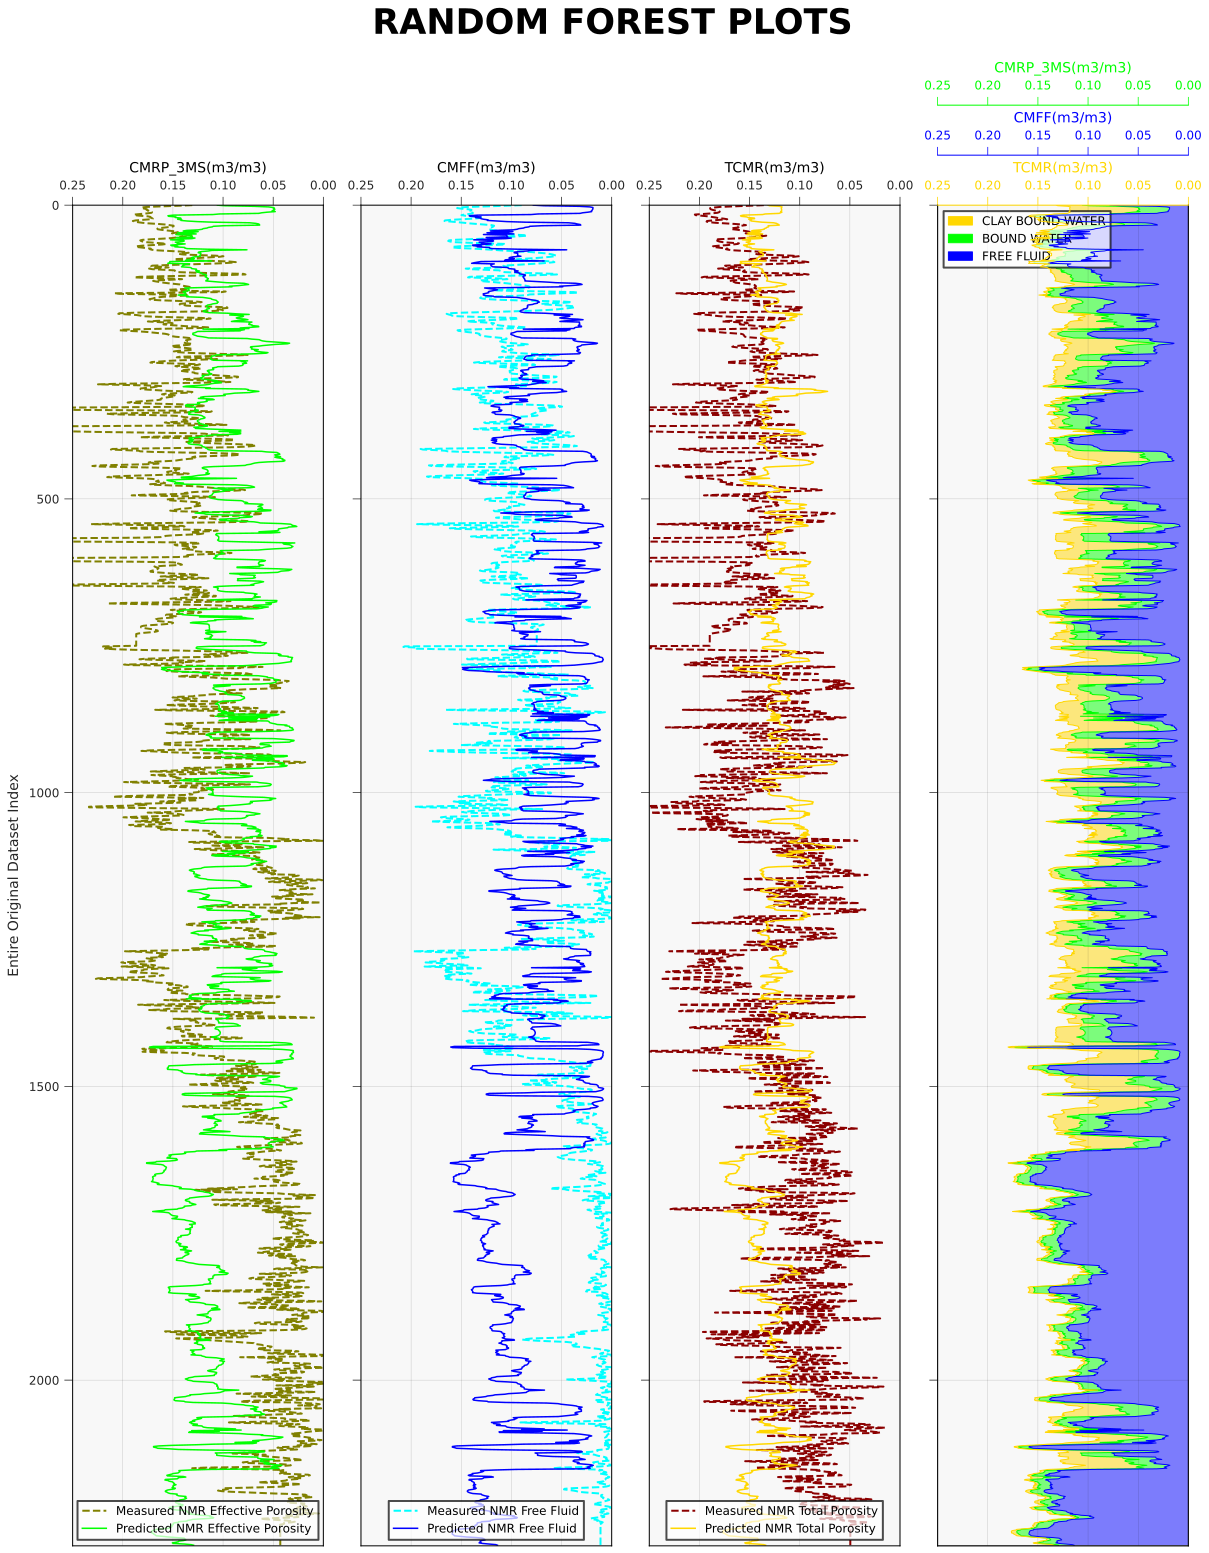

In [88]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,25))
fig.suptitle("RANDOM FOREST PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.87, wspace=0.15)


track_names = ['CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)','CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)']

#Set up the subplots grid
ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1) 
ax4 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1) 
ax5 = ax4.twiny()
ax6 = ax4.twiny()

x_ax = range(len(X))


##IMPORTANT NOTE: In this case, the "Entire Original Dataset Index" corresponds to the "Measured Depth (m)"

# First Plot
ax1.plot(y_out1_1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_predicted_out1_rf1, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Entire Original Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_out2_1_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_predicted_out2_rf1, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_out3_1_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_predicted_out3_rf1, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Fourth Plot
ax4.plot(y_predicted_out1_rf1, x_ax, color = "lime", lw = 1, linestyle = '-')                                                    
ax4.spines['top'].set_position(('outward',100))
ax4.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='lime') 
ax4.tick_params(axis='x', colors='lime', labelsize=12)
ax4.spines["top"].set_edgecolor("lime")

ax5.plot(y_predicted_out2_rf1, x_ax, color = "blue", lw = 1, linestyle = '-' )
ax5.spines['top'].set_position(('outward',50))
ax5.set_xlabel('CMFF(m3/m3)', fontsize=14, color='blue') 
ax5.tick_params(axis='x', colors='blue', labelsize=12)
ax5.spines["top"].set_edgecolor("blue")

ax6.plot(y_predicted_out3_rf1, x_ax, color = "gold", lw = 1, linestyle = '-' )                                                  
ax6.spines['top'].set_position(('outward',0))
ax6.set_xlabel('TCMR(m3/m3)', fontsize=14, color='gold')
ax6.tick_params(axis='x', colors='gold', labelsize=12)
ax6.spines["top"].set_edgecolor("gold")

# Add shading in Fifth Track with fill_betweenx(y, left handside value, x)
ax4.fill_betweenx(x_ax,y_predicted_out2_rf1,0,                   facecolor ='blue', alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out1_rf1,y_predicted_out2_rf1, facecolor='lime',    alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out3_rf1,y_predicted_out1_rf1, facecolor='gold',    alpha=0.5, interpolate=True)

# Create legend for Fifth Track 
Clay_Bound_Water = mpatches.Patch(color='gold'   , label='CLAY BOUND WATER')
Bound_Water      = mpatches.Patch(color='lime'   , label='BOUND WATER')
Free_Fluid       = mpatches.Patch(color='blue'   , label='FREE FLUID')
legend4 = ax4.legend(handles=[Clay_Bound_Water, Bound_Water, Free_Fluid], loc='upper left', fontsize='large', framealpha=0.7)



# Set xlim() and ylim()
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(2282,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
for ax in [ax6]:
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(color='black',lw=0.4)
for ax in [ax5,ax6]:
    ax.grid(visible=False)

# Hide tick labels on the y-axis
for ax in [ax2,ax3,ax4,ax5,ax6]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3,legend4]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

**GRADIENT BOOSTING**

In [89]:
# Load the trained and tuned Gradient Boosting Model
GradientBoostingModel = pd.read_pickle('gradient_boosting.pickle')

In [90]:
# Print the Model 
GradientBoostingModel

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.3,
                                                         max_depth=5,
                                                         n_estimators=250,
                                                         random_state=42))

In [91]:
# Compute new predictions by using the "unseen data" of WELL 1-BRSA-1116-RJS

predictors = ["GR","HCAL","PEFZ","RHOZ","DTCO","NPHI","AT90"]  
outputs = ["CMRP_3MS","CMFF","TCMR"]  # They are predicted at the same time 

X = df1[predictors]
y = df1[outputs]

In [92]:
y_predicted_gb1 = GradientBoostingModel.predict(X)

In [93]:
# Extract the predicted values for output 1, output 2 and output 3
y_predicted_out1_gb1 = y_predicted_gb1[:, 0]
y_predicted_out2_gb1 = y_predicted_gb1[:, 1]
y_predicted_out3_gb1 = y_predicted_gb1[:, 2]

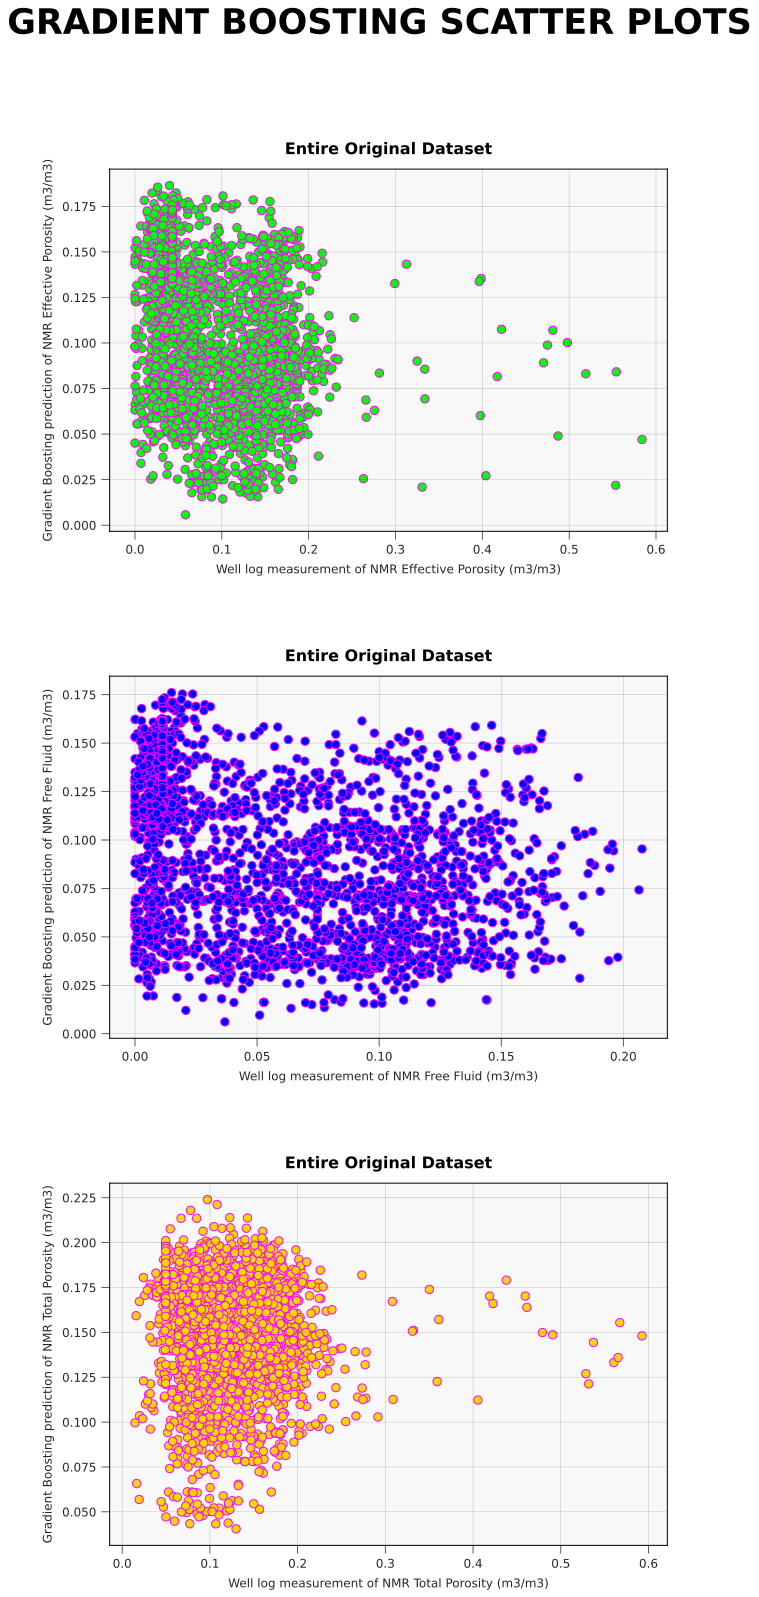

In [94]:
# Gradient Boosting Scatter Plots 
fig, ax = plt.subplots(3,1, figsize=(10,25))
fig.suptitle("GRADIENT BOOSTING SCATTER PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((3,1),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((3,1),(1,0),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((3,1),(2,0),rowspan=1,colspan=1) 


# First Scatter Plot
ax1.scatter(y_out1_1, y_predicted_out1_gb1, s=70, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well log measurement of NMR Effective Porosity (m3/m3)', fontsize=12) 
ax1.set_ylabel('Gradient Boosting prediction of NMR Effective Porosity (m3/m3)', fontsize=12)
ax1.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax1.set_xlim(,)
#ax1.set_ylim(,)
#ax1.set_xticks(np.arange(,,))
#ax1.set_yticks(np.arange(,,))

# Second Scatter Plot
ax2.scatter(y_out2_1,y_predicted_out2_gb1, s=70, c='blue', edgecolors='magenta')
ax2.set_xlabel('Well log measurement of NMR Free Fluid (m3/m3)', fontsize=12) 
ax2.set_ylabel('Gradient Boosting prediction of NMR Free Fluid (m3/m3)', fontsize=12)
ax2.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax2.set_xlim(,)
#ax2.set_ylim(,)
#ax2.set_xticks(np.arange(,,))
#ax2.set_yticks(np.arange(,,))

# Third Scatter Plot 
ax3.scatter(y_out3_1,y_predicted_out3_gb1, s=70, c='gold', edgecolors='magenta')
ax3.set_xlabel('Well log measurement of NMR Total Porosity (m3/m3)', fontsize=12) 
ax3.set_ylabel('Gradient Boosting prediction of NMR Total Porosity (m3/m3)', fontsize=12)
ax3.set_title('Entire Original Dataset', fontsize=16, fontweight='bold')
#ax3.set_xlim(,)
#ax3.set_ylim(,)
#ax3.set_xticks(np.arange(,,))
#ax3.set_yticks(np.arange(,,))


# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3]:
    ax.grid(color='black',lw=0.5)

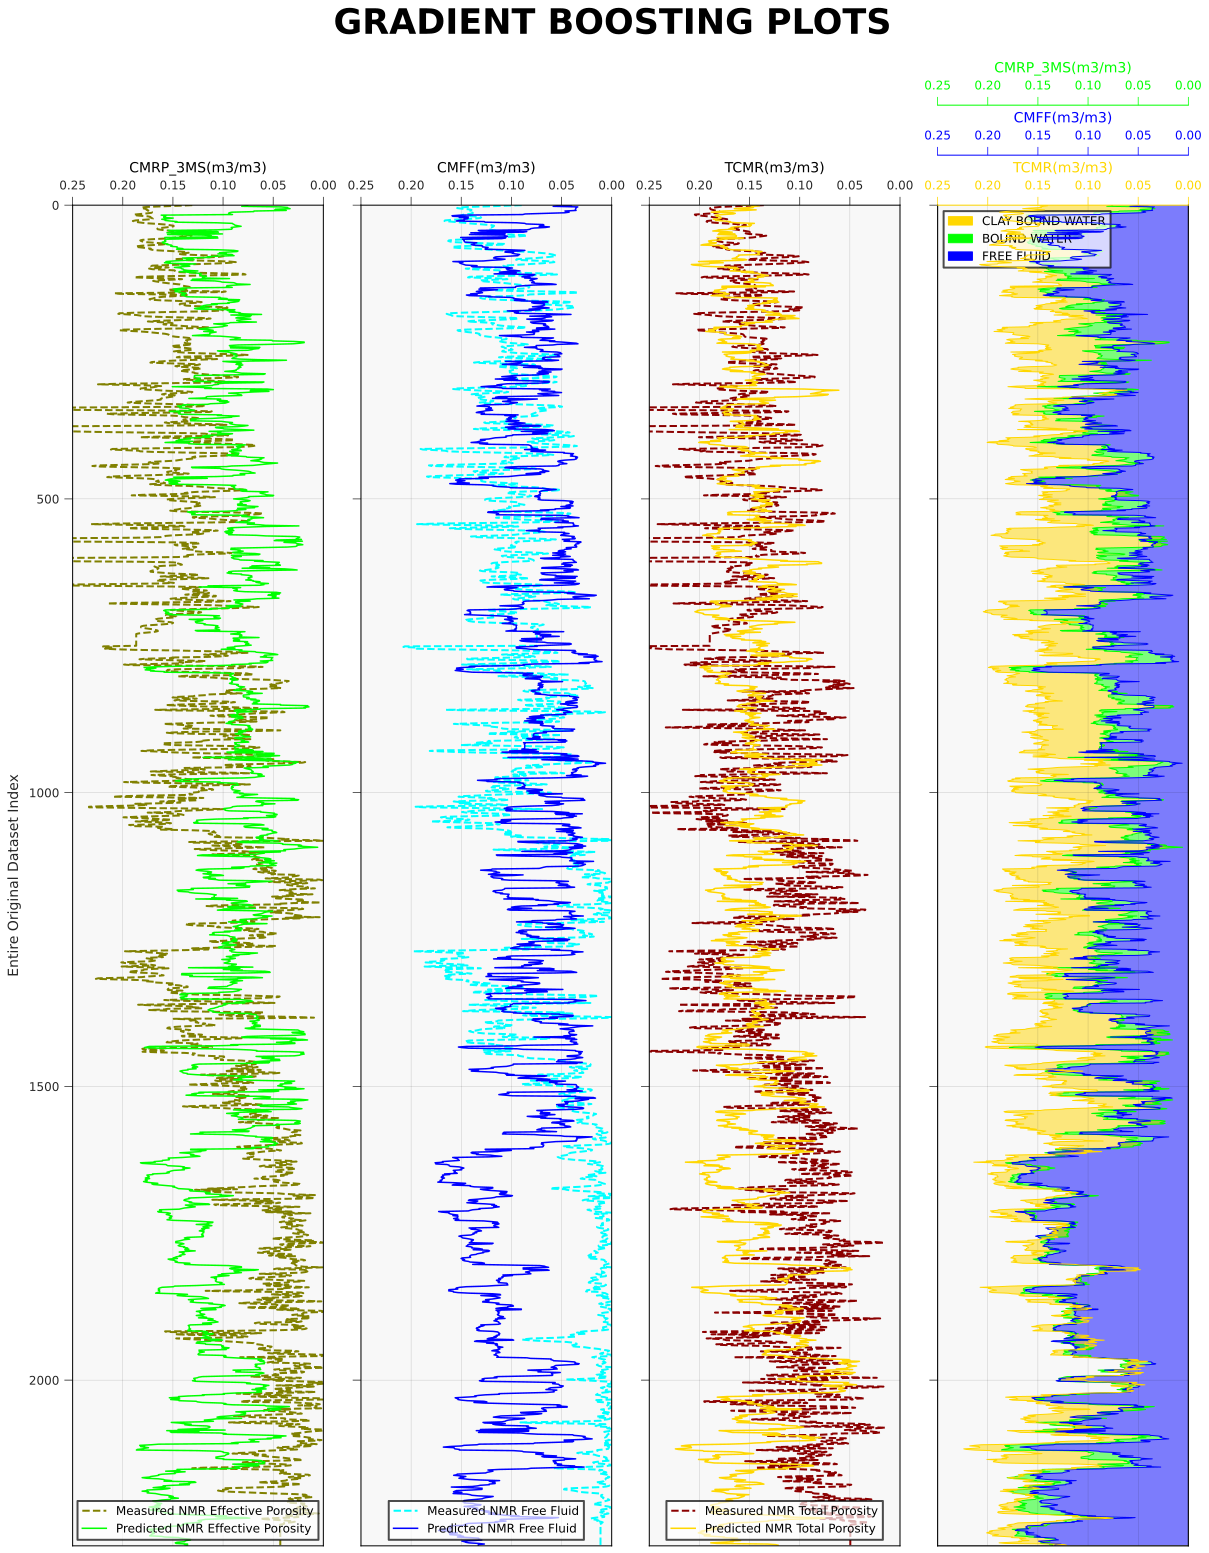

In [95]:
# Another way to perform comparison between the well log measurements and the predicted values 
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,25))
fig.suptitle("GRADIENT BOOSTING PLOTS", fontsize=35, fontweight='bold')
fig.subplots_adjust(top=0.87, wspace=0.15)


track_names = ['CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)','CMRP_3MS(m3/m3)','CMFF(m3/m3)','TCMR(m3/m3)']

#Set up the subplots grid
ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1) 
ax2 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1) 
ax3 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1) 
ax4 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1) 
ax5 = ax4.twiny()
ax6 = ax4.twiny()

x_ax = range(len(X))


##IMPORTANT NOTE: In this case, the "Entire Original Dataset Index" corresponds to the "Measured Depth (m)"

# First Plot
ax1.plot(y_out1_1_, x_ax, color = "olive", lw = 2, linestyle = '--')
ax1.plot(y_predicted_out1_gb1, x_ax, color = "lime", lw = 1.5, linestyle = '-')  
ax1.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='black') 
ax1.set_ylabel('Entire Original Dataset Index',fontsize=14)
legend1 = ax1.legend(["Measured NMR Effective Porosity", "Predicted NMR Effective Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Second Plot
ax2.plot(y_out2_1_, x_ax, color = "aqua", lw = 2, linestyle = '--')
ax2.plot(y_predicted_out2_gb1, x_ax, color = "blue", lw = 1.5, linestyle = '-')
ax2.set_xlabel('CMFF(m3/m3)',fontsize=14, color='black')
legend2 = ax2.legend(["Measured NMR Free Fluid", "Predicted NMR Free Fluid"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Third Plot 
ax3.plot(y_out3_1_, x_ax, color = "darkred", lw = 2, linestyle = '--')
ax3.plot(y_predicted_out3_gb1, x_ax, color = "gold", lw = 1.5, linestyle = '-')
ax3.set_xlabel('TCMR(m3/m3)',fontsize=14, color='black')
legend3 = ax3.legend(["Measured NMR Total Porosity", "Predicted NMR Total Porosity"], loc= 'lower center',fontsize='large', framealpha=0.7)


# Fourth Plot
ax4.plot(y_predicted_out1_gb1, x_ax, color = "lime", lw = 1, linestyle = '-')                                                    
ax4.spines['top'].set_position(('outward',100))
ax4.set_xlabel('CMRP_3MS(m3/m3)',fontsize=14, color='lime') 
ax4.tick_params(axis='x', colors='lime', labelsize=12)
ax4.spines["top"].set_edgecolor("lime")

ax5.plot(y_predicted_out2_gb1, x_ax, color = "blue", lw = 1, linestyle = '-' )
ax5.spines['top'].set_position(('outward',50))
ax5.set_xlabel('CMFF(m3/m3)', fontsize=14, color='blue') 
ax5.tick_params(axis='x', colors='blue', labelsize=12)
ax5.spines["top"].set_edgecolor("blue")

ax6.plot(y_predicted_out3_gb1, x_ax, color = "gold", lw = 1, linestyle = '-' )                                                  
ax6.spines['top'].set_position(('outward',0))
ax6.set_xlabel('TCMR(m3/m3)', fontsize=14, color='gold')
ax6.tick_params(axis='x', colors='gold', labelsize=12)
ax6.spines["top"].set_edgecolor("gold")

# Add shading in Fifth Track with fill_betweenx(y, left handside value, x)
ax4.fill_betweenx(x_ax,y_predicted_out2_gb1,0,                    facecolor='blue', alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out1_gb1,y_predicted_out2_gb1, facecolor='lime',    alpha=0.5, interpolate=True)
ax4.fill_betweenx(x_ax,y_predicted_out3_gb1,y_predicted_out1_gb1, facecolor='gold',    alpha=0.5, interpolate=True)

# Create legend for Fifth Track 
Clay_Bound_Water = mpatches.Patch(color='gold'   , label='CLAY BOUND WATER')
Bound_Water      = mpatches.Patch(color='lime'   , label='BOUND WATER')
Free_Fluid       = mpatches.Patch(color='blue', label='FREE FLUID')
legend4 = ax4.legend(handles=[Clay_Bound_Water, Bound_Water, Free_Fluid], loc='upper left', fontsize='large', framealpha=0.7)



# Set xlim() and ylim()
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xlim(0.25,0)
    ax.set_ylim(2282,0) 
    
# Add a black border to each subplot
for ax in [ax1,ax2,ax3]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
for ax in [ax6]:
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')   
    
# Set font size of the tick labels
for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(color='black',lw=0.4)
for ax in [ax5,ax6]:
    ax.grid(visible=False)

# Hide tick labels on the y-axis
for ax in [ax2,ax3,ax4,ax5,ax6]:
    plt.setp(ax.get_yticklabels(), visible=False)
    
# Set border properties of the legend 
for legend in [legend1,legend2,legend3,legend4]:
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor('black')
    
# Set xlabel and xticks position 
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticks_position("top")

<span style='color:crimson'> <span style="font-size:19px;"> **Performance Regression/Evaluation Metrics**

**RANDOM FOREST MODEL**

In [96]:
# List of variables 
data = [y_out1_1_, y_out2_1_, y_out3_1_]
predicted_data = [y_predicted_out1_rf1, y_predicted_out2_rf1, y_predicted_out3_rf1]


# Create "for loop" that calculates the Regression Metrics for each variable, separately
def regression_metrics_rf1():
    for i in range(len(data)):
        
        r2 = r2_score(data[i], predicted_data[i])
        r2 = round(r2,4)
        r2 = r2*100
        
        rmse = mean_squared_error(data[i], predicted_data[i], squared = False) # By default squared is True. If True returns MSE value, if False returns RMSE value
        rmse = round(rmse,4)
    
        mse = mean_squared_error(data[i], predicted_data[i], squared = True)
        mse = round(mse,4)
    
        mae = mean_absolute_error(data[i], predicted_data[i])
        mae = round(mae,4)
        
        print("Regression metrics for Variable", i+1)
        print("Coefficient of Determination:", r2)
        print("Root Mean Squared Error:", rmse)
        print("Mean Squared Error:", mse)
        print("Mean Absolute Error:", mae)
        print("="*90)

In [97]:
# Call the function
regression_metrics_rf1()

Regression metrics for Variable 1
Coefficient of Determination: -53.32
Root Mean Squared Error: 0.0802
Mean Squared Error: 0.0064
Mean Absolute Error: 0.0653
Regression metrics for Variable 2
Coefficient of Determination: -122.94
Root Mean Squared Error: 0.0752
Mean Squared Error: 0.0057
Mean Absolute Error: 0.0632
Regression metrics for Variable 3
Coefficient of Determination: -21.25
Root Mean Squared Error: 0.0623
Mean Squared Error: 0.0039
Mean Absolute Error: 0.0458


**GRADIENT BOOSTING MODEL**

In [98]:
# List of variables 
data = [y_out1_1_, y_out2_1_, y_out3_1_]
predicted_data = [y_predicted_out1_gb1, y_predicted_out2_gb1, y_predicted_out3_gb1]


# Create "for loop" that calculates the Regression Metrics for each variable, separately
def regression_metrics_gb1():
    for i in range(len(data)):
        
        r2 = r2_score(data[i], predicted_data[i])
        r2 = round(r2,4)
        r2 = r2*100
        
        rmse = mean_squared_error(data[i], predicted_data[i], squared = False) # By default squared is True. If True returns MSE value, if False returns RMSE value
        rmse = round(rmse,4)
    
        mse = mean_squared_error(data[i], predicted_data[i], squared = True)
        mse = round(mse,4)
    
        mae = mean_absolute_error(data[i], predicted_data[i])
        mae = round(mae,4)
        
        print("Regression metrics for Variable", i+1)
        print("Coefficient of Determination:", r2)
        print("Root Mean Squared Error:", rmse)
        print("Mean Squared Error:", mse)
        print("Mean Absolute Error:", mae)
        print("="*90)

In [99]:
# Call the function
regression_metrics_gb1()

Regression metrics for Variable 1
Coefficient of Determination: -57.099999999999994
Root Mean Squared Error: 0.0812
Mean Squared Error: 0.0066
Mean Absolute Error: 0.0652
Regression metrics for Variable 2
Coefficient of Determination: -118.24
Root Mean Squared Error: 0.0744
Mean Squared Error: 0.0055
Mean Absolute Error: 0.0617
Regression metrics for Variable 3
Coefficient of Determination: -40.32
Root Mean Squared Error: 0.067
Mean Squared Error: 0.0045
Mean Absolute Error: 0.0503


**Final Comment**: the ML models exhibit excellent predictive performance on the training well 3-BRSA-1215-RJS, but their performance is significantly poor when predicting the test well 1-BRSA-1116-RJS.